In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os

from ops import *
from utils import *

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [3]:
if not os.path.isdir('./sample_faces/'):
    os.mkdir('./sample_faces/')
if not os.path.isdir('./new_samples/'):
    os.mkdir('./new_samples/')

In [4]:
DATA_PATH = './archive/img_align_celeba/img_align_celeba/' # Path to the dataset with celebA faces

Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=64*8 # Length of first tensor in generator

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image
MERGE_Y = 8

In [5]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

In [6]:
from os.path import join
def visualize(data_path, n_cols=5, n_rows=1):
    plt.figure(figsize = (3*n_cols,3*n_rows))
    for n, filename in enumerate(np.random.choice(os.listdir(data_path), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        img = plt.imread(join(data_path, filename))
        plt.imshow(img)
        plt.title(filename)
    plt.show()

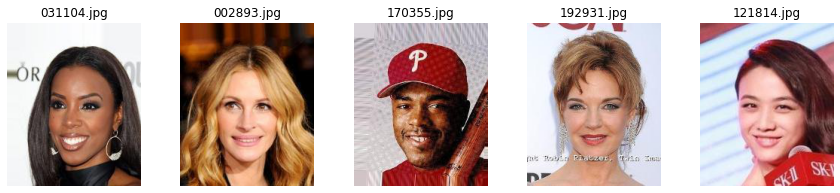

In [7]:
visualize(DATA_PATH)

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [8]:
def generator(z, is_training):
    # Firstly let's reshape input vector into 3-d tensor. 
    z_ = linear(z, GENERATOR_DENSE_SIZE * 4 * 4, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    
    """
    Your code goes here.
    """
    gen_batch_norm_0 = batch_norm(name='gen_batch_norm_0')
    h_0_bn = gen_batch_norm_0(h_in, is_training)
    h_0_a = lrelu(h_0_bn, name='gen_lr_0')
    
    h_1 = deconv2d(h_0_a, output_shape=[BATCH_SIZE, 8, 8, 512], name='gen_deconv2d_1')
    gen_batch_norm_1 = batch_norm(name='gen_batch_norm_1')
    h_1_bn = gen_batch_norm_1(h_1, is_training)
    h_1_a = lrelu(h_1_bn, name='gen_lr_1')
    h_1_a_dr = tf.nn.dropout(h_1_a, 0.5, name='gen_dr_1')
    
    h_2 = deconv2d(h_1_a_dr, output_shape=[BATCH_SIZE, 16, 16, 256], name='gen_deconv2d_2')
    gen_batch_norm_2 = batch_norm(name='gen_batch_norm_2')
    h_2_bn = gen_batch_norm_2(h_2, is_training)
    h_2_a = lrelu(h_2_bn, name='gen_lr_2')
    h_2_a_dr = tf.nn.dropout(h_2_a, 0.5, name='gen_dr_2')
    
    h_3 = deconv2d(h_2_a_dr, output_shape=[BATCH_SIZE, 32, 32, 128], name='gen_deconv2d_3')
    gen_batch_norm_3 = batch_norm(name='gen_batch_norm_3')
    h_3_bn = gen_batch_norm_3(h_3, is_training)
    h_3_a = lrelu(h_3_bn, name='gen_lr_3')
    
    h_out = deconv2d(h_3_a, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS],
            name='gen_out')

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [9]:
def discriminator(image, is_training, batch_norms=None):
    """
    Your code goes here.
    """
    h_0 = conv2d(image, output_dim=32, name='dsc_conv2d_0')
    dsc_batch_norm_0 = batch_norm(name='dsc_batch_norm_0')
    h_0_bn = dsc_batch_norm_0(h_0, is_training)
    h_0_a = lrelu(h_0_bn, name='dsc_lr_0')
    h_0_p = tf.layers.average_pooling2d(h_0_a, pool_size=(2, 2), strides=2, name='dsc_pool_0')
    
    h_1 = conv2d(h_0_p, output_dim=64, name='dsc_conv2d_1')
    dsc_batch_norm_1 = batch_norm(name='dsc_batch_norm_1')
    h_1_bn = dsc_batch_norm_1(h_1, is_training)
    h_1_a = lrelu(h_1_bn, name='dsc_lr_1')
    h_1_p = tf.layers.average_pooling2d(h_1_a, pool_size=(2, 2), strides=2, name='dsc_pool_1')
    
    h_2 = conv2d(h_1_p, output_dim=128, name='dsc_conv2d_2')
    dsc_batch_norm_2 = batch_norm(name='dsc_batch_norm_2')
    h_2_bn = dsc_batch_norm_2(h_2, is_training)
    h_2_a = lrelu(h_2_bn, name='dsc_lr_2')
    h_2_p = tf.layers.average_pooling2d(h_2_a, pool_size=(2, 2), strides=2, name='dsc_pool_2')
    
    h_flat = tf.layers.flatten(h_2_p)
    h_linear = linear(h_flat, 256, 'dsc_h_linear')
    h_linear_a = lrelu(h_linear, name='dsc_lr_4')
    
    linear_out = linear(h_linear_a, 1, 'linear_out')
    
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [10]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    G = generator(z, is_training)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    
    # If you use batch norms from ops define them here (like batch_norms = [batch_norm(name='d_bn0')])
    # and pass to discriminator function instances.
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.AveragePooling2D instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.


Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [11]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real_logits)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake_logits)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake_logits)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [12]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'dsc_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'gen_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars)

Load data:

In [13]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))
assert(len(data) > 0), "Length of training data should be more than zero"

print(len(data))

202599


Functions for training and evaluations.

In [14]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [15]:
# get images into the right shape
from skimage.transform import resize

def get_resize_transform_image(image_path):
    return transform(resize(plt.imread(image_path), 
                            (IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS), 
                            preserve_range=True, 
                            mode='reflect', 
                            anti_aliasing=True))

In [16]:
def train(sess, load_dir=None, save_frequency=100, sample_frequency=100, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=25, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(0, batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_resize_transform_image(batch_file) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim,
                    feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples, [MERGE_X, MERGE_Y],
                            os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)))
                print("Sample")

In [17]:
data = data[:30000]

with tf.Session() as sess:
    train(sess, save_dir='checkpoint')

Epoch: [ 0] [   0/ 468] time: 4.8492, d_loss: 1.38633287, g_loss: 0.69316936
Epoch: [ 0] [   1/ 468] time: 8.1526, d_loss: 1.38658690, g_loss: 0.69314969
Epoch: [ 0] [   2/ 468] time: 11.3660, d_loss: 1.38720131, g_loss: 0.69255012
Epoch: [ 0] [   3/ 468] time: 14.6479, d_loss: 1.38815749, g_loss: 0.69088697
Epoch: [ 0] [   4/ 468] time: 17.9219, d_loss: 1.38964605, g_loss: 0.68738347
Epoch: [ 0] [   5/ 468] time: 21.2612, d_loss: 1.39132571, g_loss: 0.68215752
Epoch: [ 0] [   6/ 468] time: 24.5172, d_loss: 1.39078069, g_loss: 0.67481923
Epoch: [ 0] [   7/ 468] time: 27.7601, d_loss: 1.39977312, g_loss: 0.66640019
Epoch: [ 0] [   8/ 468] time: 31.1015, d_loss: 1.39787793, g_loss: 0.65908885
Epoch: [ 0] [   9/ 468] time: 34.5363, d_loss: 1.40602183, g_loss: 0.65382415
Epoch: [ 0] [  10/ 468] time: 37.9168, d_loss: 1.40025485, g_loss: 0.66351831
Epoch: [ 0] [  11/ 468] time: 41.2943, d_loss: 1.37207258, g_loss: 0.68936658
Epoch: [ 0] [  12/ 468] time: 44.7120, d_loss: 1.34540939, g_loss:

Epoch: [ 0] [ 104/ 468] time: 359.1250, d_loss: 1.40804648, g_loss: 0.68643522
Epoch: [ 0] [ 105/ 468] time: 362.5805, d_loss: 1.40617561, g_loss: 0.69099677
Epoch: [ 0] [ 106/ 468] time: 365.9893, d_loss: 1.39966631, g_loss: 0.69409180
Epoch: [ 0] [ 107/ 468] time: 369.3792, d_loss: 1.39355540, g_loss: 0.70006990
Epoch: [ 0] [ 108/ 468] time: 372.7476, d_loss: 1.39201403, g_loss: 0.70148492
Epoch: [ 0] [ 109/ 468] time: 376.1901, d_loss: 1.39005959, g_loss: 0.69990069
Epoch: [ 0] [ 110/ 468] time: 379.5684, d_loss: 1.39677298, g_loss: 0.69580126
Epoch: [ 0] [ 111/ 468] time: 382.9664, d_loss: 1.40389299, g_loss: 0.68649966
Epoch: [ 0] [ 112/ 468] time: 386.3454, d_loss: 1.39546347, g_loss: 0.69251347
Epoch: [ 0] [ 113/ 468] time: 389.7081, d_loss: 1.39893770, g_loss: 0.69335341
Epoch: [ 0] [ 114/ 468] time: 393.0918, d_loss: 1.39048457, g_loss: 0.69662011
Epoch: [ 0] [ 115/ 468] time: 396.5468, d_loss: 1.39164019, g_loss: 0.70204115
Epoch: [ 0] [ 116/ 468] time: 399.9433, d_loss: 1.39

Epoch: [ 0] [ 208/ 468] time: 714.5557, d_loss: 1.36978078, g_loss: 0.69918346
Epoch: [ 0] [ 209/ 468] time: 717.9508, d_loss: 1.37391198, g_loss: 0.70837951
Epoch: [ 0] [ 210/ 468] time: 721.3660, d_loss: 1.36947012, g_loss: 0.71464610
Epoch: [ 0] [ 211/ 468] time: 724.7363, d_loss: 1.36696589, g_loss: 0.71483946
Epoch: [ 0] [ 212/ 468] time: 728.1510, d_loss: 1.38325930, g_loss: 0.71081257
Epoch: [ 0] [ 213/ 468] time: 731.5419, d_loss: 1.36781883, g_loss: 0.71763039
Epoch: [ 0] [ 214/ 468] time: 734.9305, d_loss: 1.37270975, g_loss: 0.70679343
Epoch: [ 0] [ 215/ 468] time: 738.3155, d_loss: 1.37230563, g_loss: 0.69955450
Epoch: [ 0] [ 216/ 468] time: 741.7164, d_loss: 1.38407350, g_loss: 0.69779253
Epoch: [ 0] [ 217/ 468] time: 745.0900, d_loss: 1.38477457, g_loss: 0.69006622
Epoch: [ 0] [ 218/ 468] time: 748.5068, d_loss: 1.39385819, g_loss: 0.70003283
Epoch: [ 0] [ 219/ 468] time: 751.8913, d_loss: 1.38521099, g_loss: 0.70442462
Epoch: [ 0] [ 220/ 468] time: 755.2880, d_loss: 1.39

Epoch: [ 0] [ 312/ 468] time: 1069.5125, d_loss: 1.37734747, g_loss: 0.70456624
Epoch: [ 0] [ 313/ 468] time: 1072.9166, d_loss: 1.37886930, g_loss: 0.70168877
Epoch: [ 0] [ 314/ 468] time: 1076.2717, d_loss: 1.38572884, g_loss: 0.69594312
Epoch: [ 0] [ 315/ 468] time: 1079.6992, d_loss: 1.38547099, g_loss: 0.69036043
Epoch: [ 0] [ 316/ 468] time: 1083.1366, d_loss: 1.39159679, g_loss: 0.68611324
Epoch: [ 0] [ 317/ 468] time: 1086.5436, d_loss: 1.38785815, g_loss: 0.68301511
Epoch: [ 0] [ 318/ 468] time: 1089.9188, d_loss: 1.38881612, g_loss: 0.68962091
Epoch: [ 0] [ 319/ 468] time: 1093.3781, d_loss: 1.37958837, g_loss: 0.70766211
Epoch: [ 0] [ 320/ 468] time: 1096.7630, d_loss: 1.36362147, g_loss: 0.71134454
Epoch: [ 0] [ 321/ 468] time: 1100.1483, d_loss: 1.36964440, g_loss: 0.70209646
Epoch: [ 0] [ 322/ 468] time: 1103.5246, d_loss: 1.38201499, g_loss: 0.69424403
Epoch: [ 0] [ 323/ 468] time: 1106.9336, d_loss: 1.39769435, g_loss: 0.68917882
Epoch: [ 0] [ 324/ 468] time: 1110.3006,

Epoch: [ 0] [ 415/ 468] time: 1420.9502, d_loss: 1.40059876, g_loss: 0.69541705
Epoch: [ 0] [ 416/ 468] time: 1424.3627, d_loss: 1.40225744, g_loss: 0.68845809
Epoch: [ 0] [ 417/ 468] time: 1427.7332, d_loss: 1.40118575, g_loss: 0.68736982
Epoch: [ 0] [ 418/ 468] time: 1431.1357, d_loss: 1.39229858, g_loss: 0.69707251
Epoch: [ 0] [ 419/ 468] time: 1434.5241, d_loss: 1.40294218, g_loss: 0.71007574
Epoch: [ 0] [ 420/ 468] time: 1437.9175, d_loss: 1.39953446, g_loss: 0.70447326
Epoch: [ 0] [ 421/ 468] time: 1441.2936, d_loss: 1.39147770, g_loss: 0.69388217
Epoch: [ 0] [ 422/ 468] time: 1444.7364, d_loss: 1.40938413, g_loss: 0.67619371
Epoch: [ 0] [ 423/ 468] time: 1448.1024, d_loss: 1.40371299, g_loss: 0.68688345
Epoch: [ 0] [ 424/ 468] time: 1451.5559, d_loss: 1.38030362, g_loss: 0.70583183
Epoch: [ 0] [ 425/ 468] time: 1454.9254, d_loss: 1.39190578, g_loss: 0.69407195
Epoch: [ 0] [ 426/ 468] time: 1458.3821, d_loss: 1.37307715, g_loss: 0.70324516
Epoch: [ 0] [ 427/ 468] time: 1461.7702,

Epoch: [ 1] [  50/ 468] time: 1772.9329, d_loss: 1.38050961, g_loss: 0.68690801
Epoch: [ 1] [  51/ 468] time: 1776.4005, d_loss: 1.38956308, g_loss: 0.69019824
Epoch: [ 1] [  52/ 468] time: 1779.7750, d_loss: 1.39003193, g_loss: 0.69170451
Epoch: [ 1] [  53/ 468] time: 1783.1680, d_loss: 1.39415395, g_loss: 0.69113851
Epoch: [ 1] [  54/ 468] time: 1786.5605, d_loss: 1.38281250, g_loss: 0.69611442
Epoch: [ 1] [  55/ 468] time: 1789.9666, d_loss: 1.38150299, g_loss: 0.69496644
Epoch: [ 1] [  56/ 468] time: 1793.3679, d_loss: 1.37577558, g_loss: 0.69676185
Epoch: [ 1] [  57/ 468] time: 1796.8322, d_loss: 1.39315629, g_loss: 0.68713033
Epoch: [ 1] [  58/ 468] time: 1800.2170, d_loss: 1.38791382, g_loss: 0.69557476
Epoch: [ 1] [  59/ 468] time: 1803.6412, d_loss: 1.39907467, g_loss: 0.68651623
Epoch: [ 1] [  60/ 468] time: 1807.0368, d_loss: 1.38814354, g_loss: 0.69013822
Epoch: [ 1] [  61/ 468] time: 1810.4377, d_loss: 1.39057755, g_loss: 0.69050002
Epoch: [ 1] [  62/ 468] time: 1813.8712,

Epoch: [ 1] [ 153/ 468] time: 2123.9853, d_loss: 1.38996446, g_loss: 0.68597758
Epoch: [ 1] [ 154/ 468] time: 2127.3546, d_loss: 1.39163387, g_loss: 0.69134331
Epoch: [ 1] [ 155/ 468] time: 2130.7572, d_loss: 1.39003742, g_loss: 0.69171774
Epoch: [ 1] [ 156/ 468] time: 2134.1471, d_loss: 1.38320279, g_loss: 0.68814325
Epoch: [ 1] [ 157/ 468] time: 2137.5494, d_loss: 1.38657236, g_loss: 0.69766498
Epoch: [ 1] [ 158/ 468] time: 2140.9507, d_loss: 1.38167131, g_loss: 0.70289296
Epoch: [ 1] [ 159/ 468] time: 2144.3286, d_loss: 1.38609695, g_loss: 0.69683611
Epoch: [ 1] [ 160/ 468] time: 2147.7100, d_loss: 1.38876462, g_loss: 0.68352091
Epoch: [ 1] [ 161/ 468] time: 2151.1033, d_loss: 1.37934446, g_loss: 0.68549824
Epoch: [ 1] [ 162/ 468] time: 2154.4947, d_loss: 1.38087189, g_loss: 0.68709689
Epoch: [ 1] [ 163/ 468] time: 2157.9279, d_loss: 1.38169193, g_loss: 0.69282824
Epoch: [ 1] [ 164/ 468] time: 2161.3297, d_loss: 1.39192307, g_loss: 0.68171269
Epoch: [ 1] [ 165/ 468] time: 2164.7293,

Epoch: [ 1] [ 256/ 468] time: 2475.3446, d_loss: 1.38284659, g_loss: 0.69025356
Epoch: [ 1] [ 257/ 468] time: 2478.7704, d_loss: 1.40213132, g_loss: 0.68935800
Epoch: [ 1] [ 258/ 468] time: 2482.1890, d_loss: 1.38156915, g_loss: 0.69009578
Epoch: [ 1] [ 259/ 468] time: 2485.5985, d_loss: 1.42098677, g_loss: 0.68315494
Epoch: [ 1] [ 260/ 468] time: 2489.0157, d_loss: 1.40682149, g_loss: 0.70073408
Epoch: [ 1] [ 261/ 468] time: 2492.4182, d_loss: 1.38842130, g_loss: 0.70111847
Epoch: [ 1] [ 262/ 468] time: 2495.7906, d_loss: 1.41277242, g_loss: 0.67162597
Epoch: [ 1] [ 263/ 468] time: 2499.1943, d_loss: 1.39609265, g_loss: 0.67608237
Epoch: [ 1] [ 264/ 468] time: 2502.6042, d_loss: 1.40224648, g_loss: 0.69516706
Epoch: [ 1] [ 265/ 468] time: 2505.9878, d_loss: 1.38871932, g_loss: 0.71076536
Epoch: [ 1] [ 266/ 468] time: 2509.3712, d_loss: 1.40603566, g_loss: 0.68240941
Epoch: [ 1] [ 267/ 468] time: 2512.7693, d_loss: 1.40951204, g_loss: 0.68432891
Epoch: [ 1] [ 268/ 468] time: 2516.1599,

Epoch: [ 1] [ 359/ 468] time: 2826.8186, d_loss: 1.37493682, g_loss: 0.69851106
Epoch: [ 1] [ 360/ 468] time: 2830.1909, d_loss: 1.39301753, g_loss: 0.69930249
Epoch: [ 1] [ 361/ 468] time: 2833.5696, d_loss: 1.39878261, g_loss: 0.69069541
Epoch: [ 1] [ 362/ 468] time: 2836.9771, d_loss: 1.39706326, g_loss: 0.68738860
Epoch: [ 1] [ 363/ 468] time: 2840.3979, d_loss: 1.40081298, g_loss: 0.67924821
Epoch: [ 1] [ 364/ 468] time: 2843.7706, d_loss: 1.38990128, g_loss: 0.67603290
Epoch: [ 1] [ 365/ 468] time: 2847.1781, d_loss: 1.38173532, g_loss: 0.70801437
Epoch: [ 1] [ 366/ 468] time: 2850.5706, d_loss: 1.38637292, g_loss: 0.71008492
Epoch: [ 1] [ 367/ 468] time: 2853.9993, d_loss: 1.36461639, g_loss: 0.71840519
Epoch: [ 1] [ 368/ 468] time: 2857.4202, d_loss: 1.36387897, g_loss: 0.71174359
Epoch: [ 1] [ 369/ 468] time: 2860.8431, d_loss: 1.38761568, g_loss: 0.69960731
Epoch: [ 1] [ 370/ 468] time: 2864.2387, d_loss: 1.39286840, g_loss: 0.68824691
Epoch: [ 1] [ 371/ 468] time: 2867.6427,

Epoch: [ 1] [ 462/ 468] time: 3178.3643, d_loss: 1.39387369, g_loss: 0.68386483
Epoch: [ 1] [ 463/ 468] time: 3181.7764, d_loss: 1.38737941, g_loss: 0.68873549
Epoch: [ 1] [ 464/ 468] time: 3185.1554, d_loss: 1.38918352, g_loss: 0.70813292
Epoch: [ 1] [ 465/ 468] time: 3188.5417, d_loss: 1.37872565, g_loss: 0.70709252
Epoch: [ 1] [ 466/ 468] time: 3191.9344, d_loss: 1.36279452, g_loss: 0.71508861
Epoch: [ 1] [ 467/ 468] time: 3195.3166, d_loss: 1.37454939, g_loss: 0.69516027
Epoch: [ 2] [   0/ 468] time: 3198.7187, d_loss: 1.38759506, g_loss: 0.68619907
Epoch: [ 2] [   1/ 468] time: 3202.1244, d_loss: 1.37191153, g_loss: 0.68434310
Epoch: [ 2] [   2/ 468] time: 3205.5512, d_loss: 1.39145660, g_loss: 0.68338764
Epoch: [ 2] [   3/ 468] time: 3209.0375, d_loss: 1.38250566, g_loss: 0.69384557
Epoch: [ 2] [   4/ 468] time: 3212.4344, d_loss: 1.38412595, g_loss: 0.69174469
Epoch: [ 2] [   5/ 468] time: 3215.8127, d_loss: 1.37908959, g_loss: 0.68888307
Epoch: [ 2] [   6/ 468] time: 3219.2377,

Epoch: [ 2] [  97/ 468] time: 3530.1563, d_loss: 1.37146997, g_loss: 0.68341184
Epoch: [ 2] [  98/ 468] time: 3533.5388, d_loss: 1.36653244, g_loss: 0.69203562
Epoch: [ 2] [  99/ 468] time: 3536.9355, d_loss: 1.36827433, g_loss: 0.68680263
Epoch: [ 2] [ 100/ 468] time: 3540.3064, d_loss: 1.36608076, g_loss: 0.70597744
Epoch: [ 2] [ 101/ 468] time: 3543.7152, d_loss: 1.36634123, g_loss: 0.69704139
Epoch: [ 2] [ 102/ 468] time: 3547.1391, d_loss: 1.38039732, g_loss: 0.68480980
Epoch: [ 2] [ 103/ 468] time: 3550.5507, d_loss: 1.37953258, g_loss: 0.67666864
Epoch: [ 2] [ 104/ 468] time: 3553.9463, d_loss: 1.37354755, g_loss: 0.68403959
Epoch: [ 2] [ 105/ 468] time: 3557.3494, d_loss: 1.38589573, g_loss: 0.68785298
Epoch: [ 2] [ 106/ 468] time: 3560.7260, d_loss: 1.36955428, g_loss: 0.68361902
Epoch: [ 2] [ 107/ 468] time: 3564.1139, d_loss: 1.39515758, g_loss: 0.66853929
Epoch: [ 2] [ 108/ 468] time: 3567.5067, d_loss: 1.38744819, g_loss: 0.68366218
Epoch: [ 2] [ 109/ 468] time: 3570.9400,

Epoch: [ 2] [ 200/ 468] time: 3881.2748, d_loss: 1.37397027, g_loss: 0.69429457
Epoch: [ 2] [ 201/ 468] time: 3884.6662, d_loss: 1.39224648, g_loss: 0.68938577
Epoch: [ 2] [ 202/ 468] time: 3888.0450, d_loss: 1.38357770, g_loss: 0.70405030
Epoch: [ 2] [ 203/ 468] time: 3891.4227, d_loss: 1.39024305, g_loss: 0.70536053
Epoch: [ 2] [ 204/ 468] time: 3894.9078, d_loss: 1.38341522, g_loss: 0.69915020
Epoch: [ 2] [ 205/ 468] time: 3898.3007, d_loss: 1.40715134, g_loss: 0.68739176
Epoch: [ 2] [ 206/ 468] time: 3901.6785, d_loss: 1.38530087, g_loss: 0.69176221
Epoch: [ 2] [ 207/ 468] time: 3905.0806, d_loss: 1.38030863, g_loss: 0.69060171
Epoch: [ 2] [ 208/ 468] time: 3908.4693, d_loss: 1.37585104, g_loss: 0.68975776
Epoch: [ 2] [ 209/ 468] time: 3911.8915, d_loss: 1.37603009, g_loss: 0.68927121
Epoch: [ 2] [ 210/ 468] time: 3915.2802, d_loss: 1.36608529, g_loss: 0.69601488
Epoch: [ 2] [ 211/ 468] time: 3918.7139, d_loss: 1.37404585, g_loss: 0.69540203
Epoch: [ 2] [ 212/ 468] time: 3922.0918,

Epoch: [ 2] [ 303/ 468] time: 4232.1759, d_loss: 1.38705111, g_loss: 0.69485062
Epoch: [ 2] [ 304/ 468] time: 4235.5498, d_loss: 1.38187003, g_loss: 0.68873435
Epoch: [ 2] [ 305/ 468] time: 4238.9850, d_loss: 1.39648366, g_loss: 0.67977720
Epoch: [ 2] [ 306/ 468] time: 4242.3650, d_loss: 1.37224424, g_loss: 0.70176995
Epoch: [ 2] [ 307/ 468] time: 4245.8435, d_loss: 1.36128020, g_loss: 0.71061850
Epoch: [ 2] [ 308/ 468] time: 4249.2235, d_loss: 1.36383343, g_loss: 0.71341604
Epoch: [ 2] [ 309/ 468] time: 4252.6146, d_loss: 1.36605465, g_loss: 0.70338082
Epoch: [ 2] [ 310/ 468] time: 4255.9989, d_loss: 1.36630607, g_loss: 0.69054723
Epoch: [ 2] [ 311/ 468] time: 4259.3851, d_loss: 1.37782657, g_loss: 0.68784153
Epoch: [ 2] [ 312/ 468] time: 4262.7529, d_loss: 1.37627387, g_loss: 0.68950522
Epoch: [ 2] [ 313/ 468] time: 4266.1483, d_loss: 1.38052797, g_loss: 0.69287753
Epoch: [ 2] [ 314/ 468] time: 4269.5191, d_loss: 1.37996447, g_loss: 0.68168330
Epoch: [ 2] [ 315/ 468] time: 4272.9672,

Epoch: [ 2] [ 406/ 468] time: 4583.5188, d_loss: 1.38737237, g_loss: 0.68105692
Epoch: [ 2] [ 407/ 468] time: 4586.9429, d_loss: 1.38197076, g_loss: 0.68107641
Epoch: [ 2] [ 408/ 468] time: 4590.3384, d_loss: 1.38959825, g_loss: 0.66856617
Epoch: [ 2] [ 409/ 468] time: 4593.7114, d_loss: 1.39787698, g_loss: 0.66953647
Epoch: [ 2] [ 410/ 468] time: 4597.0889, d_loss: 1.38181412, g_loss: 0.69143963
Epoch: [ 2] [ 411/ 468] time: 4600.4695, d_loss: 1.38983059, g_loss: 0.69593561
Epoch: [ 2] [ 412/ 468] time: 4603.9157, d_loss: 1.40896130, g_loss: 0.69241953
Epoch: [ 2] [ 413/ 468] time: 4607.2975, d_loss: 1.41570890, g_loss: 0.68153381
Epoch: [ 2] [ 414/ 468] time: 4610.7365, d_loss: 1.38070750, g_loss: 0.68299341
Epoch: [ 2] [ 415/ 468] time: 4614.1236, d_loss: 1.38329411, g_loss: 0.67970431
Epoch: [ 2] [ 416/ 468] time: 4617.5344, d_loss: 1.37603211, g_loss: 0.68959987
Epoch: [ 2] [ 417/ 468] time: 4620.9121, d_loss: 1.37564445, g_loss: 0.69859505
Epoch: [ 2] [ 418/ 468] time: 4624.3121,

Epoch: [ 3] [  41/ 468] time: 4934.4531, d_loss: 1.40936947, g_loss: 0.68137336
Epoch: [ 3] [  42/ 468] time: 4937.8289, d_loss: 1.40268564, g_loss: 0.68247724
Epoch: [ 3] [  43/ 468] time: 4941.2223, d_loss: 1.39630461, g_loss: 0.68933696
Epoch: [ 3] [  44/ 468] time: 4944.5953, d_loss: 1.38154554, g_loss: 0.69770539
Epoch: [ 3] [  45/ 468] time: 4947.9973, d_loss: 1.38365769, g_loss: 0.69502580
Epoch: [ 3] [  46/ 468] time: 4951.3899, d_loss: 1.39041662, g_loss: 0.68289244
Epoch: [ 3] [  47/ 468] time: 4954.7783, d_loss: 1.39059770, g_loss: 0.66811693
Epoch: [ 3] [  48/ 468] time: 4958.1978, d_loss: 1.38833928, g_loss: 0.66518843
Epoch: [ 3] [  49/ 468] time: 4961.5958, d_loss: 1.40356421, g_loss: 0.67725539
Epoch: [ 3] [  50/ 468] time: 4964.9940, d_loss: 1.37626994, g_loss: 0.70786309
Epoch: [ 3] [  51/ 468] time: 4968.3581, d_loss: 1.36632991, g_loss: 0.70218492
Epoch: [ 3] [  52/ 468] time: 4971.8331, d_loss: 1.36856055, g_loss: 0.71014333
Epoch: [ 3] [  53/ 468] time: 4975.2005,

Epoch: [ 3] [ 144/ 468] time: 5285.5202, d_loss: 1.37930536, g_loss: 0.67398202
Epoch: [ 3] [ 145/ 468] time: 5288.9059, d_loss: 1.39474797, g_loss: 0.67314243
Epoch: [ 3] [ 146/ 468] time: 5292.2949, d_loss: 1.38647139, g_loss: 0.66601598
Epoch: [ 3] [ 147/ 468] time: 5295.7067, d_loss: 1.38070679, g_loss: 0.68232495
Epoch: [ 3] [ 148/ 468] time: 5299.1355, d_loss: 1.38189840, g_loss: 0.68382734
Epoch: [ 3] [ 149/ 468] time: 5302.5280, d_loss: 1.37334144, g_loss: 0.68955988
Epoch: [ 3] [ 150/ 468] time: 5305.9004, d_loss: 1.38262653, g_loss: 0.70833331
Epoch: [ 3] [ 151/ 468] time: 5309.3167, d_loss: 1.37402606, g_loss: 0.70707989
Epoch: [ 3] [ 152/ 468] time: 5312.7226, d_loss: 1.38068986, g_loss: 0.68968320
Epoch: [ 3] [ 153/ 468] time: 5316.1828, d_loss: 1.37345457, g_loss: 0.69067091
Epoch: [ 3] [ 154/ 468] time: 5319.5398, d_loss: 1.38166714, g_loss: 0.68400145
Epoch: [ 3] [ 155/ 468] time: 5322.9163, d_loss: 1.38496232, g_loss: 0.67895067
Epoch: [ 3] [ 156/ 468] time: 5326.2984,

Epoch: [ 3] [ 247/ 468] time: 5637.9514, d_loss: 1.39667296, g_loss: 0.65062994
Epoch: [ 3] [ 248/ 468] time: 5641.3652, d_loss: 1.38540447, g_loss: 0.67133844
Epoch: [ 3] [ 249/ 468] time: 5644.7569, d_loss: 1.39297569, g_loss: 0.67655826
Epoch: [ 3] [ 250/ 468] time: 5648.1530, d_loss: 1.38162327, g_loss: 0.70201159
Epoch: [ 3] [ 251/ 468] time: 5651.5340, d_loss: 1.37158954, g_loss: 0.71424794
Epoch: [ 3] [ 252/ 468] time: 5655.1080, d_loss: 1.37713289, g_loss: 0.71532822
Epoch: [ 3] [ 253/ 468] time: 5658.7681, d_loss: 1.39473259, g_loss: 0.70545435
Epoch: [ 3] [ 254/ 468] time: 5662.3811, d_loss: 1.40244603, g_loss: 0.70455891
Epoch: [ 3] [ 255/ 468] time: 5665.9672, d_loss: 1.38662481, g_loss: 0.69124949
Epoch: [ 3] [ 256/ 468] time: 5669.4254, d_loss: 1.37248731, g_loss: 0.69074202
Epoch: [ 3] [ 257/ 468] time: 5672.8558, d_loss: 1.35549045, g_loss: 0.69287044
Epoch: [ 3] [ 258/ 468] time: 5676.2608, d_loss: 1.40051603, g_loss: 0.68217933
Epoch: [ 3] [ 259/ 468] time: 5679.6508,

Epoch: [ 3] [ 350/ 468] time: 5990.5303, d_loss: 1.37054944, g_loss: 0.69210124
Epoch: [ 3] [ 351/ 468] time: 5993.9213, d_loss: 1.37420845, g_loss: 0.69287431
Epoch: [ 3] [ 352/ 468] time: 5997.3064, d_loss: 1.36685920, g_loss: 0.70006776
Epoch: [ 3] [ 353/ 468] time: 6000.7032, d_loss: 1.38069606, g_loss: 0.69829464
Epoch: [ 3] [ 354/ 468] time: 6004.1007, d_loss: 1.39830410, g_loss: 0.69907176
Epoch: [ 3] [ 355/ 468] time: 6007.4836, d_loss: 1.37033391, g_loss: 0.71139526
Epoch: [ 3] [ 356/ 468] time: 6010.8781, d_loss: 1.36459720, g_loss: 0.71121693
Epoch: [ 3] [ 357/ 468] time: 6014.3044, d_loss: 1.39094186, g_loss: 0.69499236
Epoch: [ 3] [ 358/ 468] time: 6017.7803, d_loss: 1.39612174, g_loss: 0.68279564
Epoch: [ 3] [ 359/ 468] time: 6021.1610, d_loss: 1.38402605, g_loss: 0.67543280
Epoch: [ 3] [ 360/ 468] time: 6024.5529, d_loss: 1.39377546, g_loss: 0.67568010
Epoch: [ 3] [ 361/ 468] time: 6027.9398, d_loss: 1.38981724, g_loss: 0.69281608
Epoch: [ 3] [ 362/ 468] time: 6031.3275,

Epoch: [ 3] [ 453/ 468] time: 6342.0504, d_loss: 1.39057016, g_loss: 0.69494510
Epoch: [ 3] [ 454/ 468] time: 6345.4522, d_loss: 1.37424707, g_loss: 0.71542114
Epoch: [ 3] [ 455/ 468] time: 6348.8419, d_loss: 1.38436139, g_loss: 0.70561504
Epoch: [ 3] [ 456/ 468] time: 6352.2277, d_loss: 1.38243270, g_loss: 0.69212770
Epoch: [ 3] [ 457/ 468] time: 6355.6350, d_loss: 1.38114369, g_loss: 0.68630272
Epoch: [ 3] [ 458/ 468] time: 6359.0266, d_loss: 1.39294600, g_loss: 0.66901189
Epoch: [ 3] [ 459/ 468] time: 6362.4347, d_loss: 1.37238657, g_loss: 0.70082450
Epoch: [ 3] [ 460/ 468] time: 6365.8234, d_loss: 1.36758792, g_loss: 0.72924143
Epoch: [ 3] [ 461/ 468] time: 6369.2603, d_loss: 1.36122298, g_loss: 0.72013950
Epoch: [ 3] [ 462/ 468] time: 6372.6446, d_loss: 1.36560428, g_loss: 0.70090985
Epoch: [ 3] [ 463/ 468] time: 6376.0303, d_loss: 1.38345098, g_loss: 0.69776618
Epoch: [ 3] [ 464/ 468] time: 6379.3941, d_loss: 1.41689336, g_loss: 0.69120705
Epoch: [ 3] [ 465/ 468] time: 6382.8504,

Epoch: [ 4] [  88/ 468] time: 6694.3407, d_loss: 1.37321103, g_loss: 0.70143098
Epoch: [ 4] [  89/ 468] time: 6697.7553, d_loss: 1.38055396, g_loss: 0.69434643
Epoch: [ 4] [  90/ 468] time: 6701.2027, d_loss: 1.37154341, g_loss: 0.69553387
Epoch: [ 4] [  91/ 468] time: 6704.5991, d_loss: 1.38571203, g_loss: 0.66809976
Epoch: [ 4] [  92/ 468] time: 6707.9814, d_loss: 1.38251472, g_loss: 0.68660206
Epoch: [ 4] [  93/ 468] time: 6711.3835, d_loss: 1.40332675, g_loss: 0.67500198
Epoch: [ 4] [  94/ 468] time: 6714.7745, d_loss: 1.39923394, g_loss: 0.66486651
Epoch: [ 4] [  95/ 468] time: 6718.1417, d_loss: 1.38058519, g_loss: 0.69047141
Epoch: [ 4] [  96/ 468] time: 6721.5594, d_loss: 1.39135706, g_loss: 0.69985735
Epoch: [ 4] [  97/ 468] time: 6724.9387, d_loss: 1.39658237, g_loss: 0.66947305
Epoch: [ 4] [  98/ 468] time: 6728.3336, d_loss: 1.38709688, g_loss: 0.68047607
Epoch: [ 4] [  99/ 468] time: 6731.7232, d_loss: 1.36949754, g_loss: 0.68426919
Epoch: [ 4] [ 100/ 468] time: 6735.1571,

Epoch: [ 4] [ 191/ 468] time: 7045.3759, d_loss: 1.35752738, g_loss: 0.69611245
Epoch: [ 4] [ 192/ 468] time: 7048.7899, d_loss: 1.36899161, g_loss: 0.66663682
Epoch: [ 4] [ 193/ 468] time: 7052.1990, d_loss: 1.35426903, g_loss: 0.66547537
Epoch: [ 4] [ 194/ 468] time: 7055.5732, d_loss: 1.36888099, g_loss: 0.66973758
Epoch: [ 4] [ 195/ 468] time: 7059.0368, d_loss: 1.40170991, g_loss: 0.68340492
Epoch: [ 4] [ 196/ 468] time: 7062.4199, d_loss: 1.39213967, g_loss: 0.70325965
Epoch: [ 4] [ 197/ 468] time: 7065.8079, d_loss: 1.38945627, g_loss: 0.71891868
Epoch: [ 4] [ 198/ 468] time: 7069.2032, d_loss: 1.36516905, g_loss: 0.71120358
Epoch: [ 4] [ 199/ 468] time: 7072.5840, d_loss: 1.39180720, g_loss: 0.69251025
Epoch: [ 4] [ 200/ 468] time: 7075.9705, d_loss: 1.39405358, g_loss: 0.71924603
Epoch: [ 4] [ 201/ 468] time: 7079.3414, d_loss: 1.38507450, g_loss: 0.73794138
Epoch: [ 4] [ 202/ 468] time: 7082.8140, d_loss: 1.36126459, g_loss: 0.71464074
Epoch: [ 4] [ 203/ 468] time: 7086.2323,

Epoch: [ 4] [ 294/ 468] time: 7396.6171, d_loss: 1.39031529, g_loss: 0.70410842
Epoch: [ 4] [ 295/ 468] time: 7400.0052, d_loss: 1.39612424, g_loss: 0.70449162
Epoch: [ 4] [ 296/ 468] time: 7403.3927, d_loss: 1.39144504, g_loss: 0.72226489
Epoch: [ 4] [ 297/ 468] time: 7406.7844, d_loss: 1.37337613, g_loss: 0.72543913
Epoch: [ 4] [ 298/ 468] time: 7410.2003, d_loss: 1.34893513, g_loss: 0.69189715
Epoch: [ 4] [ 299/ 468] time: 7413.5654, d_loss: 1.33050835, g_loss: 0.72498620
Epoch: [ 4] [ 300/ 468] time: 7416.9573, d_loss: 1.34769475, g_loss: 0.70676780
Epoch: [ 4] [ 301/ 468] time: 7420.3423, d_loss: 1.33034801, g_loss: 0.70768654
Epoch: [ 4] [ 302/ 468] time: 7423.7333, d_loss: 1.35256243, g_loss: 0.70067823
Epoch: [ 4] [ 303/ 468] time: 7427.1201, d_loss: 1.35715699, g_loss: 0.68342263
Epoch: [ 4] [ 304/ 468] time: 7430.4798, d_loss: 1.36214566, g_loss: 0.67216575
Epoch: [ 4] [ 305/ 468] time: 7433.8803, d_loss: 1.37534177, g_loss: 0.68684739
Epoch: [ 4] [ 306/ 468] time: 7437.2812,

Epoch: [ 4] [ 397/ 468] time: 7746.8481, d_loss: 1.37801194, g_loss: 0.67835492
Epoch: [ 4] [ 398/ 468] time: 7750.2418, d_loss: 1.37381434, g_loss: 0.72955120
Epoch: [ 4] [ 399/ 468] time: 7753.6310, d_loss: 1.36148858, g_loss: 0.75023961
Epoch: [ 4] [ 400/ 468] time: 7757.0329, d_loss: 1.35481179, g_loss: 0.70500451
Epoch: [ 4] [ 401/ 468] time: 7760.4164, d_loss: 1.36317348, g_loss: 0.67646372
Epoch: [ 4] [ 402/ 468] time: 7763.8141, d_loss: 1.36108947, g_loss: 0.69903713
Epoch: [ 4] [ 403/ 468] time: 7767.2018, d_loss: 1.39268923, g_loss: 0.72021556
Epoch: [ 4] [ 404/ 468] time: 7770.5709, d_loss: 1.40940809, g_loss: 0.70444345
Epoch: [ 4] [ 405/ 468] time: 7773.9664, d_loss: 1.39367056, g_loss: 0.69471252
Epoch: [ 4] [ 406/ 468] time: 7777.3954, d_loss: 1.39536977, g_loss: 0.66307431
Epoch: [ 4] [ 407/ 468] time: 7780.7781, d_loss: 1.40801668, g_loss: 0.65082991
Epoch: [ 4] [ 408/ 468] time: 7784.1586, d_loss: 1.38167548, g_loss: 0.67984414
Epoch: [ 4] [ 409/ 468] time: 7787.6036,

Epoch: [ 5] [  32/ 468] time: 8098.0797, d_loss: 1.36949468, g_loss: 0.71532214
Epoch: [ 5] [  33/ 468] time: 8101.4926, d_loss: 1.38722014, g_loss: 0.70314592
Epoch: [ 5] [  34/ 468] time: 8104.9012, d_loss: 1.37788892, g_loss: 0.68393499
Epoch: [ 5] [  35/ 468] time: 8108.2855, d_loss: 1.36658454, g_loss: 0.66819966
Epoch: [ 5] [  36/ 468] time: 8111.7232, d_loss: 1.37142432, g_loss: 0.71500206
Epoch: [ 5] [  37/ 468] time: 8115.1307, d_loss: 1.35914731, g_loss: 0.72556406
Epoch: [ 5] [  38/ 468] time: 8118.5222, d_loss: 1.37982845, g_loss: 0.71359634
Epoch: [ 5] [  39/ 468] time: 8121.9387, d_loss: 1.38465190, g_loss: 0.68381417
Epoch: [ 5] [  40/ 468] time: 8125.2988, d_loss: 1.39541554, g_loss: 0.64704180
Epoch: [ 5] [  41/ 468] time: 8128.7201, d_loss: 1.39320087, g_loss: 0.67237592
Epoch: [ 5] [  42/ 468] time: 8132.0911, d_loss: 1.39053190, g_loss: 0.66880733
Epoch: [ 5] [  43/ 468] time: 8135.4856, d_loss: 1.39252448, g_loss: 0.66649830
Epoch: [ 5] [  44/ 468] time: 8138.8649,

Epoch: [ 5] [ 135/ 468] time: 8449.2756, d_loss: 1.37637472, g_loss: 0.67320406
Epoch: [ 5] [ 136/ 468] time: 8452.6743, d_loss: 1.34852171, g_loss: 0.69298631
Epoch: [ 5] [ 137/ 468] time: 8456.0839, d_loss: 1.36889124, g_loss: 0.68358254
Epoch: [ 5] [ 138/ 468] time: 8459.4539, d_loss: 1.40151548, g_loss: 0.66630411
Epoch: [ 5] [ 139/ 468] time: 8462.8464, d_loss: 1.38612437, g_loss: 0.70965719
Epoch: [ 5] [ 140/ 468] time: 8466.2435, d_loss: 1.36800671, g_loss: 0.72810340
Epoch: [ 5] [ 141/ 468] time: 8469.6118, d_loss: 1.40064394, g_loss: 0.74200070
Epoch: [ 5] [ 142/ 468] time: 8473.0096, d_loss: 1.37615967, g_loss: 0.73786414
Epoch: [ 5] [ 143/ 468] time: 8476.3680, d_loss: 1.37081170, g_loss: 0.70728618
Epoch: [ 5] [ 144/ 468] time: 8479.7739, d_loss: 1.40345120, g_loss: 0.67427468
Epoch: [ 5] [ 145/ 468] time: 8483.1447, d_loss: 1.43086708, g_loss: 0.65294218
Epoch: [ 5] [ 146/ 468] time: 8486.5203, d_loss: 1.39681768, g_loss: 0.67364627
Epoch: [ 5] [ 147/ 468] time: 8489.9083,

Epoch: [ 5] [ 238/ 468] time: 8799.8945, d_loss: 1.33006918, g_loss: 0.72716701
Epoch: [ 5] [ 239/ 468] time: 8803.2948, d_loss: 1.37053299, g_loss: 0.69326186
Epoch: [ 5] [ 240/ 468] time: 8806.6712, d_loss: 1.35766339, g_loss: 0.70726705
Epoch: [ 5] [ 241/ 468] time: 8810.0505, d_loss: 1.35496271, g_loss: 0.72975016
Epoch: [ 5] [ 242/ 468] time: 8813.4180, d_loss: 1.34753084, g_loss: 0.74766386
Epoch: [ 5] [ 243/ 468] time: 8816.8246, d_loss: 1.36720598, g_loss: 0.74676704
Epoch: [ 5] [ 244/ 468] time: 8820.2721, d_loss: 1.33086348, g_loss: 0.72523785
Epoch: [ 5] [ 245/ 468] time: 8823.6604, d_loss: 1.34832740, g_loss: 0.69869870
Epoch: [ 5] [ 246/ 468] time: 8827.0625, d_loss: 1.34224677, g_loss: 0.70372182
Epoch: [ 5] [ 247/ 468] time: 8830.4546, d_loss: 1.37091041, g_loss: 0.70367157
Epoch: [ 5] [ 248/ 468] time: 8833.8652, d_loss: 1.38302445, g_loss: 0.71529377
Epoch: [ 5] [ 249/ 468] time: 8837.3021, d_loss: 1.36802483, g_loss: 0.72345853
Epoch: [ 5] [ 250/ 468] time: 8840.7444,

Epoch: [ 5] [ 341/ 468] time: 9151.2954, d_loss: 1.35556698, g_loss: 0.66179872
Epoch: [ 5] [ 342/ 468] time: 9154.6929, d_loss: 1.31180310, g_loss: 0.71461624
Epoch: [ 5] [ 343/ 468] time: 9158.0963, d_loss: 1.36727595, g_loss: 0.69533408
Epoch: [ 5] [ 344/ 468] time: 9161.4748, d_loss: 1.39214969, g_loss: 0.68158591
Epoch: [ 5] [ 345/ 468] time: 9164.8809, d_loss: 1.39401102, g_loss: 0.70878136
Epoch: [ 5] [ 346/ 468] time: 9168.2580, d_loss: 1.36630177, g_loss: 0.70610750
Epoch: [ 5] [ 347/ 468] time: 9171.6633, d_loss: 1.39286470, g_loss: 0.70003325
Epoch: [ 5] [ 348/ 468] time: 9175.0798, d_loss: 1.37360191, g_loss: 0.68287009
Epoch: [ 5] [ 349/ 468] time: 9178.5174, d_loss: 1.36606598, g_loss: 0.70344102
Epoch: [ 5] [ 350/ 468] time: 9181.9580, d_loss: 1.34888089, g_loss: 0.73438752
Epoch: [ 5] [ 351/ 468] time: 9185.3368, d_loss: 1.35282600, g_loss: 0.75049853
Epoch: [ 5] [ 352/ 468] time: 9188.7230, d_loss: 1.34824514, g_loss: 0.73525345
Epoch: [ 5] [ 353/ 468] time: 9192.1123,

Epoch: [ 5] [ 444/ 468] time: 9502.2441, d_loss: 1.38479543, g_loss: 0.64759457
Epoch: [ 5] [ 445/ 468] time: 9505.6406, d_loss: 1.37533140, g_loss: 0.70197898
Epoch: [ 5] [ 446/ 468] time: 9509.0276, d_loss: 1.36216867, g_loss: 0.68541431
Epoch: [ 5] [ 447/ 468] time: 9512.4030, d_loss: 1.34506238, g_loss: 0.69393253
Epoch: [ 5] [ 448/ 468] time: 9515.7993, d_loss: 1.38403630, g_loss: 0.66413379
Epoch: [ 5] [ 449/ 468] time: 9519.1581, d_loss: 1.36673737, g_loss: 0.66520584
Epoch: [ 5] [ 450/ 468] time: 9522.5697, d_loss: 1.34596300, g_loss: 0.69301832
Epoch: [ 5] [ 451/ 468] time: 9525.9422, d_loss: 1.35876465, g_loss: 0.69860351
Epoch: [ 5] [ 452/ 468] time: 9529.3447, d_loss: 1.36106145, g_loss: 0.70544958
Epoch: [ 5] [ 453/ 468] time: 9532.7195, d_loss: 1.37414753, g_loss: 0.68925422
Epoch: [ 5] [ 454/ 468] time: 9536.0996, d_loss: 1.35644650, g_loss: 0.68815756
Epoch: [ 5] [ 455/ 468] time: 9539.4884, d_loss: 1.35858941, g_loss: 0.71998692
Epoch: [ 5] [ 456/ 468] time: 9542.9149,

Epoch: [ 6] [  79/ 468] time: 9853.2114, d_loss: 1.35558629, g_loss: 0.73595947
Epoch: [ 6] [  80/ 468] time: 9856.6697, d_loss: 1.36425138, g_loss: 0.72612047
Epoch: [ 6] [  81/ 468] time: 9860.0616, d_loss: 1.34022045, g_loss: 0.72274184
Epoch: [ 6] [  82/ 468] time: 9863.4492, d_loss: 1.32957315, g_loss: 0.72526610
Epoch: [ 6] [  83/ 468] time: 9866.8258, d_loss: 1.31810308, g_loss: 0.75389612
Epoch: [ 6] [  84/ 468] time: 9870.2093, d_loss: 1.28896284, g_loss: 0.75371647
Epoch: [ 6] [  85/ 468] time: 9873.6457, d_loss: 1.34036005, g_loss: 0.73192471
Epoch: [ 6] [  86/ 468] time: 9877.0119, d_loss: 1.38799906, g_loss: 0.71071988
Epoch: [ 6] [  87/ 468] time: 9880.4130, d_loss: 1.34989214, g_loss: 0.71397036
Epoch: [ 6] [  88/ 468] time: 9883.8271, d_loss: 1.33747005, g_loss: 0.70457709
Epoch: [ 6] [  89/ 468] time: 9887.2056, d_loss: 1.33220410, g_loss: 0.70987761
Epoch: [ 6] [  90/ 468] time: 9890.5854, d_loss: 1.35571766, g_loss: 0.68207526
Epoch: [ 6] [  91/ 468] time: 9893.9648,

Epoch: [ 6] [ 181/ 468] time: 10200.4547, d_loss: 1.37027860, g_loss: 0.70593590
Epoch: [ 6] [ 182/ 468] time: 10203.8632, d_loss: 1.37448215, g_loss: 0.71468127
Epoch: [ 6] [ 183/ 468] time: 10207.2486, d_loss: 1.36813593, g_loss: 0.71463895
Epoch: [ 6] [ 184/ 468] time: 10210.6528, d_loss: 1.40015912, g_loss: 0.69666851
Epoch: [ 6] [ 185/ 468] time: 10214.0544, d_loss: 1.37281477, g_loss: 0.66275632
Epoch: [ 6] [ 186/ 468] time: 10217.4414, d_loss: 1.37150764, g_loss: 0.67863870
Epoch: [ 6] [ 187/ 468] time: 10220.8320, d_loss: 1.35483360, g_loss: 0.67985094
Epoch: [ 6] [ 188/ 468] time: 10224.1985, d_loss: 1.36126590, g_loss: 0.71673143
Epoch: [ 6] [ 189/ 468] time: 10227.6247, d_loss: 1.35011697, g_loss: 0.74765766
Epoch: [ 6] [ 190/ 468] time: 10231.0368, d_loss: 1.33473349, g_loss: 0.77148485
Epoch: [ 6] [ 191/ 468] time: 10234.4560, d_loss: 1.37342525, g_loss: 0.73460728
Saved model
Sample
Epoch: [ 6] [ 192/ 468] time: 10238.7075, d_loss: 1.34364223, g_loss: 0.70963287
Epoch: [ 

Epoch: [ 6] [ 282/ 468] time: 10543.9735, d_loss: 1.37428284, g_loss: 0.68454218
Epoch: [ 6] [ 283/ 468] time: 10547.4010, d_loss: 1.37068677, g_loss: 0.70350373
Epoch: [ 6] [ 284/ 468] time: 10550.7807, d_loss: 1.39024353, g_loss: 0.70222878
Epoch: [ 6] [ 285/ 468] time: 10554.1655, d_loss: 1.37910104, g_loss: 0.71679783
Epoch: [ 6] [ 286/ 468] time: 10557.5433, d_loss: 1.35567212, g_loss: 0.74366152
Epoch: [ 6] [ 287/ 468] time: 10560.9761, d_loss: 1.40116537, g_loss: 0.73434395
Epoch: [ 6] [ 288/ 468] time: 10564.3837, d_loss: 1.41779661, g_loss: 0.68811095
Epoch: [ 6] [ 289/ 468] time: 10567.7629, d_loss: 1.37599516, g_loss: 0.69159603
Epoch: [ 6] [ 290/ 468] time: 10571.1715, d_loss: 1.38953388, g_loss: 0.69593191
Epoch: [ 6] [ 291/ 468] time: 10574.5518, d_loss: 1.36845291, g_loss: 0.72188175
Saved model
Sample
Epoch: [ 6] [ 292/ 468] time: 10578.8383, d_loss: 1.37389135, g_loss: 0.70950723
Epoch: [ 6] [ 293/ 468] time: 10582.2250, d_loss: 1.39235139, g_loss: 0.70520425
Epoch: [ 

Epoch: [ 6] [ 383/ 468] time: 10887.9069, d_loss: 1.38696074, g_loss: 0.71813154
Epoch: [ 6] [ 384/ 468] time: 10891.3091, d_loss: 1.36629987, g_loss: 0.70101655
Epoch: [ 6] [ 385/ 468] time: 10894.6855, d_loss: 1.36639619, g_loss: 0.70723796
Epoch: [ 6] [ 386/ 468] time: 10898.0700, d_loss: 1.38423204, g_loss: 0.71429205
Epoch: [ 6] [ 387/ 468] time: 10901.4608, d_loss: 1.33528149, g_loss: 0.75272220
Epoch: [ 6] [ 388/ 468] time: 10904.8985, d_loss: 1.35915768, g_loss: 0.68015897
Epoch: [ 6] [ 389/ 468] time: 10908.2637, d_loss: 1.37697530, g_loss: 0.65003133
Epoch: [ 6] [ 390/ 468] time: 10911.6430, d_loss: 1.33460248, g_loss: 0.67920244
Epoch: [ 6] [ 391/ 468] time: 10915.0284, d_loss: 1.33122969, g_loss: 0.69449949
Saved model
Sample
Epoch: [ 6] [ 392/ 468] time: 10919.5104, d_loss: 1.31459033, g_loss: 0.71620786
Epoch: [ 6] [ 393/ 468] time: 10922.9003, d_loss: 1.37541878, g_loss: 0.71020150
Epoch: [ 6] [ 394/ 468] time: 10926.2799, d_loss: 1.33404040, g_loss: 0.70602739
Epoch: [ 

Epoch: [ 7] [  16/ 468] time: 11231.9078, d_loss: 1.36426580, g_loss: 0.72713768
Epoch: [ 7] [  17/ 468] time: 11235.2890, d_loss: 1.35606873, g_loss: 0.75960958
Epoch: [ 7] [  18/ 468] time: 11238.6743, d_loss: 1.38128459, g_loss: 0.70435286
Epoch: [ 7] [  19/ 468] time: 11242.0497, d_loss: 1.35477936, g_loss: 0.67498368
Epoch: [ 7] [  20/ 468] time: 11245.4295, d_loss: 1.34220445, g_loss: 0.68856013
Epoch: [ 7] [  21/ 468] time: 11248.8674, d_loss: 1.37537646, g_loss: 0.70450342
Epoch: [ 7] [  22/ 468] time: 11252.2509, d_loss: 1.38162172, g_loss: 0.70942712
Epoch: [ 7] [  23/ 468] time: 11255.6365, d_loss: 1.33649039, g_loss: 0.71536696
Saved model
Sample
Epoch: [ 7] [  24/ 468] time: 11260.1015, d_loss: 1.37860107, g_loss: 0.70972216
Epoch: [ 7] [  25/ 468] time: 11263.5075, d_loss: 1.38062310, g_loss: 0.68557245
Epoch: [ 7] [  26/ 468] time: 11266.8800, d_loss: 1.36221886, g_loss: 0.67128861
Epoch: [ 7] [  27/ 468] time: 11270.2757, d_loss: 1.30443358, g_loss: 0.71890014
Epoch: [ 

Epoch: [ 7] [ 117/ 468] time: 11575.7799, d_loss: 1.38053346, g_loss: 0.70926178
Epoch: [ 7] [ 118/ 468] time: 11579.1506, d_loss: 1.36061954, g_loss: 0.72175294
Epoch: [ 7] [ 119/ 468] time: 11582.5268, d_loss: 1.35452771, g_loss: 0.72788250
Epoch: [ 7] [ 120/ 468] time: 11585.9211, d_loss: 1.37417030, g_loss: 0.72110021
Epoch: [ 7] [ 121/ 468] time: 11589.3031, d_loss: 1.34944344, g_loss: 0.76727968
Epoch: [ 7] [ 122/ 468] time: 11592.6913, d_loss: 1.36485767, g_loss: 0.72697157
Epoch: [ 7] [ 123/ 468] time: 11596.0820, d_loss: 1.33480334, g_loss: 0.70922995
Saved model
Sample
Epoch: [ 7] [ 124/ 468] time: 11600.5225, d_loss: 1.34924805, g_loss: 0.72207367
Epoch: [ 7] [ 125/ 468] time: 11603.9102, d_loss: 1.39648509, g_loss: 0.68614542
Epoch: [ 7] [ 126/ 468] time: 11607.2840, d_loss: 1.36041677, g_loss: 0.69247031
Epoch: [ 7] [ 127/ 468] time: 11610.6876, d_loss: 1.34549356, g_loss: 0.68279767
Epoch: [ 7] [ 128/ 468] time: 11614.0612, d_loss: 1.34127450, g_loss: 0.67540014
Epoch: [ 

Epoch: [ 7] [ 218/ 468] time: 11919.9069, d_loss: 1.35912490, g_loss: 0.68760478
Epoch: [ 7] [ 219/ 468] time: 11923.2892, d_loss: 1.33621073, g_loss: 0.68509382
Epoch: [ 7] [ 220/ 468] time: 11926.7120, d_loss: 1.36541474, g_loss: 0.67087120
Epoch: [ 7] [ 221/ 468] time: 11930.1465, d_loss: 1.38291955, g_loss: 0.70651066
Epoch: [ 7] [ 222/ 468] time: 11933.5689, d_loss: 1.34930313, g_loss: 0.75665146
Epoch: [ 7] [ 223/ 468] time: 11936.9696, d_loss: 1.35485530, g_loss: 0.75377071
Saved model
Sample
Epoch: [ 7] [ 224/ 468] time: 11941.4248, d_loss: 1.36148143, g_loss: 0.71619600
Epoch: [ 7] [ 225/ 468] time: 11944.8008, d_loss: 1.38756490, g_loss: 0.70025682
Epoch: [ 7] [ 226/ 468] time: 11948.1920, d_loss: 1.34055698, g_loss: 0.70727038
Epoch: [ 7] [ 227/ 468] time: 11951.6175, d_loss: 1.37308621, g_loss: 0.71871895
Epoch: [ 7] [ 228/ 468] time: 11955.0370, d_loss: 1.39841616, g_loss: 0.73760247
Epoch: [ 7] [ 229/ 468] time: 11958.4227, d_loss: 1.34637046, g_loss: 0.73697150
Epoch: [ 

Epoch: [ 7] [ 319/ 468] time: 12264.1355, d_loss: 1.31180382, g_loss: 0.70440233
Epoch: [ 7] [ 320/ 468] time: 12267.5407, d_loss: 1.31819701, g_loss: 0.71451151
Epoch: [ 7] [ 321/ 468] time: 12270.9190, d_loss: 1.36485350, g_loss: 0.69081163
Epoch: [ 7] [ 322/ 468] time: 12274.3218, d_loss: 1.34524679, g_loss: 0.70489287
Epoch: [ 7] [ 323/ 468] time: 12277.7512, d_loss: 1.36707115, g_loss: 0.72019506
Saved model
Sample
Epoch: [ 7] [ 324/ 468] time: 12281.9986, d_loss: 1.35263860, g_loss: 0.71664584
Epoch: [ 7] [ 325/ 468] time: 12285.3772, d_loss: 1.36447930, g_loss: 0.68943608
Epoch: [ 7] [ 326/ 468] time: 12288.7560, d_loss: 1.35803437, g_loss: 0.68094885
Epoch: [ 7] [ 327/ 468] time: 12292.1275, d_loss: 1.34919381, g_loss: 0.71225095
Epoch: [ 7] [ 328/ 468] time: 12295.5193, d_loss: 1.32679713, g_loss: 0.73503911
Epoch: [ 7] [ 329/ 468] time: 12298.9168, d_loss: 1.35287929, g_loss: 0.72170013
Epoch: [ 7] [ 330/ 468] time: 12302.3353, d_loss: 1.34474993, g_loss: 0.69245684
Epoch: [ 

Epoch: [ 7] [ 420/ 468] time: 12608.1174, d_loss: 1.34166932, g_loss: 0.73526406
Epoch: [ 7] [ 421/ 468] time: 12611.5008, d_loss: 1.34700990, g_loss: 0.71450102
Epoch: [ 7] [ 422/ 468] time: 12614.9116, d_loss: 1.32039094, g_loss: 0.73589182
Epoch: [ 7] [ 423/ 468] time: 12618.3721, d_loss: 1.35000801, g_loss: 0.76213205
Saved model
Sample
Epoch: [ 7] [ 424/ 468] time: 12622.6541, d_loss: 1.35251498, g_loss: 0.74683523
Epoch: [ 7] [ 425/ 468] time: 12626.0131, d_loss: 1.38654852, g_loss: 0.67472565
Epoch: [ 7] [ 426/ 468] time: 12629.4105, d_loss: 1.34585452, g_loss: 0.69171035
Epoch: [ 7] [ 427/ 468] time: 12632.8038, d_loss: 1.38558030, g_loss: 0.66125083
Epoch: [ 7] [ 428/ 468] time: 12636.2154, d_loss: 1.34810841, g_loss: 0.71794760
Epoch: [ 7] [ 429/ 468] time: 12639.6123, d_loss: 1.39589226, g_loss: 0.68125641
Epoch: [ 7] [ 430/ 468] time: 12642.9985, d_loss: 1.37580264, g_loss: 0.64437234
Epoch: [ 7] [ 431/ 468] time: 12646.3765, d_loss: 1.34843051, g_loss: 0.68326265
Epoch: [ 

Epoch: [ 8] [  53/ 468] time: 12952.1740, d_loss: 1.34709144, g_loss: 0.72888279
Epoch: [ 8] [  54/ 468] time: 12955.5596, d_loss: 1.33005011, g_loss: 0.77026391
Epoch: [ 8] [  55/ 468] time: 12958.9634, d_loss: 1.34719360, g_loss: 0.72913682
Saved model
Sample
Epoch: [ 8] [  56/ 468] time: 12963.2456, d_loss: 1.35319507, g_loss: 0.72712851
Epoch: [ 8] [  57/ 468] time: 12966.6436, d_loss: 1.34485292, g_loss: 0.73215240
Epoch: [ 8] [  58/ 468] time: 12970.0299, d_loss: 1.37698221, g_loss: 0.71211898
Epoch: [ 8] [  59/ 468] time: 12973.4250, d_loss: 1.37056231, g_loss: 0.72284341
Epoch: [ 8] [  60/ 468] time: 12976.8245, d_loss: 1.36287010, g_loss: 0.68099988
Epoch: [ 8] [  61/ 468] time: 12980.1892, d_loss: 1.34701085, g_loss: 0.69604051
Epoch: [ 8] [  62/ 468] time: 12983.5929, d_loss: 1.35604966, g_loss: 0.70061922
Epoch: [ 8] [  63/ 468] time: 12986.9697, d_loss: 1.35226882, g_loss: 0.74745870
Epoch: [ 8] [  64/ 468] time: 12990.4348, d_loss: 1.31029153, g_loss: 0.76296163
Epoch: [ 

Epoch: [ 8] [ 154/ 468] time: 13296.5293, d_loss: 1.36554718, g_loss: 0.76587033
Epoch: [ 8] [ 155/ 468] time: 13299.9111, d_loss: 1.34396243, g_loss: 0.67755246
Saved model
Sample
Epoch: [ 8] [ 156/ 468] time: 13304.1834, d_loss: 1.42048180, g_loss: 0.67682219
Epoch: [ 8] [ 157/ 468] time: 13307.5584, d_loss: 1.35374534, g_loss: 0.76807886
Epoch: [ 8] [ 158/ 468] time: 13311.0066, d_loss: 1.32600498, g_loss: 0.74794173
Epoch: [ 8] [ 159/ 468] time: 13314.3649, d_loss: 1.32667160, g_loss: 0.78018308
Epoch: [ 8] [ 160/ 468] time: 13317.7854, d_loss: 1.37820852, g_loss: 0.75625002
Epoch: [ 8] [ 161/ 468] time: 13321.1814, d_loss: 1.34308457, g_loss: 0.74199253
Epoch: [ 8] [ 162/ 468] time: 13324.5830, d_loss: 1.36474442, g_loss: 0.70518541
Epoch: [ 8] [ 163/ 468] time: 13327.9655, d_loss: 1.33735323, g_loss: 0.67534673
Epoch: [ 8] [ 164/ 468] time: 13331.3593, d_loss: 1.30599844, g_loss: 0.71728730
Epoch: [ 8] [ 165/ 468] time: 13334.7541, d_loss: 1.31130791, g_loss: 0.70986062
Epoch: [ 

Epoch: [ 8] [ 255/ 468] time: 13641.0217, d_loss: 1.35572791, g_loss: 0.65084702
Saved model
Sample
Epoch: [ 8] [ 256/ 468] time: 13645.4663, d_loss: 1.36142063, g_loss: 0.64135730
Epoch: [ 8] [ 257/ 468] time: 13648.8555, d_loss: 1.39917564, g_loss: 0.72931910
Epoch: [ 8] [ 258/ 468] time: 13652.2882, d_loss: 1.35528827, g_loss: 0.75303280
Epoch: [ 8] [ 259/ 468] time: 13655.6819, d_loss: 1.37377644, g_loss: 0.78548861
Epoch: [ 8] [ 260/ 468] time: 13659.0743, d_loss: 1.33363199, g_loss: 0.78079188
Epoch: [ 8] [ 261/ 468] time: 13662.5051, d_loss: 1.32643890, g_loss: 0.76840270
Epoch: [ 8] [ 262/ 468] time: 13665.8875, d_loss: 1.36724389, g_loss: 0.72920102
Epoch: [ 8] [ 263/ 468] time: 13669.2624, d_loss: 1.36840844, g_loss: 0.72626376
Epoch: [ 8] [ 264/ 468] time: 13672.7272, d_loss: 1.40794754, g_loss: 0.70625812
Epoch: [ 8] [ 265/ 468] time: 13676.0916, d_loss: 1.35432744, g_loss: 0.72282708
Epoch: [ 8] [ 266/ 468] time: 13679.5242, d_loss: 1.33202136, g_loss: 0.75040519
Epoch: [ 

Sample
Epoch: [ 8] [ 356/ 468] time: 13987.1031, d_loss: 1.34632194, g_loss: 0.69423532
Epoch: [ 8] [ 357/ 468] time: 13990.5088, d_loss: 1.36511135, g_loss: 0.67516017
Epoch: [ 8] [ 358/ 468] time: 13993.9098, d_loss: 1.33366513, g_loss: 0.71349812
Epoch: [ 8] [ 359/ 468] time: 13997.2923, d_loss: 1.37029457, g_loss: 0.67088354
Epoch: [ 8] [ 360/ 468] time: 14000.6814, d_loss: 1.34920084, g_loss: 0.74069470
Epoch: [ 8] [ 361/ 468] time: 14004.1171, d_loss: 1.33718300, g_loss: 0.75161529
Epoch: [ 8] [ 362/ 468] time: 14007.5798, d_loss: 1.35820627, g_loss: 0.75740921
Epoch: [ 8] [ 363/ 468] time: 14010.9638, d_loss: 1.36733007, g_loss: 0.74472415
Epoch: [ 8] [ 364/ 468] time: 14014.3539, d_loss: 1.32798672, g_loss: 0.72170621
Epoch: [ 8] [ 365/ 468] time: 14017.7257, d_loss: 1.38078666, g_loss: 0.68773949
Epoch: [ 8] [ 366/ 468] time: 14021.1626, d_loss: 1.36766839, g_loss: 0.69603562
Epoch: [ 8] [ 367/ 468] time: 14024.5421, d_loss: 1.34403825, g_loss: 0.68607342
Epoch: [ 8] [ 368/ 46

Epoch: [ 8] [ 457/ 468] time: 14331.7624, d_loss: 1.31565380, g_loss: 0.77788597
Epoch: [ 8] [ 458/ 468] time: 14335.1798, d_loss: 1.33634877, g_loss: 0.72813058
Epoch: [ 8] [ 459/ 468] time: 14338.6256, d_loss: 1.31460392, g_loss: 0.72574919
Epoch: [ 8] [ 460/ 468] time: 14342.0252, d_loss: 1.34792185, g_loss: 0.69192594
Epoch: [ 8] [ 461/ 468] time: 14345.4019, d_loss: 1.33454871, g_loss: 0.71400702
Epoch: [ 8] [ 462/ 468] time: 14348.7721, d_loss: 1.31576407, g_loss: 0.72258413
Epoch: [ 8] [ 463/ 468] time: 14352.2042, d_loss: 1.31419396, g_loss: 0.68864572
Epoch: [ 8] [ 464/ 468] time: 14355.5734, d_loss: 1.35784125, g_loss: 0.63618279
Epoch: [ 8] [ 465/ 468] time: 14358.9560, d_loss: 1.37165880, g_loss: 0.62534970
Epoch: [ 8] [ 466/ 468] time: 14362.3590, d_loss: 1.38323212, g_loss: 0.62726343
Epoch: [ 8] [ 467/ 468] time: 14365.7524, d_loss: 1.35161710, g_loss: 0.68994689
Epoch: [ 9] [   0/ 468] time: 14369.1444, d_loss: 1.37181568, g_loss: 0.61421812
Epoch: [ 9] [   1/ 468] time

Epoch: [ 9] [  90/ 468] time: 14676.2315, d_loss: 1.30795789, g_loss: 0.68907946
Epoch: [ 9] [  91/ 468] time: 14679.6777, d_loss: 1.34495533, g_loss: 0.69780773
Epoch: [ 9] [  92/ 468] time: 14683.0582, d_loss: 1.33261096, g_loss: 0.68884784
Epoch: [ 9] [  93/ 468] time: 14686.4506, d_loss: 1.32820082, g_loss: 0.74036694
Epoch: [ 9] [  94/ 468] time: 14689.8434, d_loss: 1.30368710, g_loss: 0.73250353
Epoch: [ 9] [  95/ 468] time: 14693.2606, d_loss: 1.33735263, g_loss: 0.73041379
Epoch: [ 9] [  96/ 468] time: 14696.6995, d_loss: 1.36054564, g_loss: 0.73321140
Epoch: [ 9] [  97/ 468] time: 14700.0859, d_loss: 1.31236136, g_loss: 0.79086065
Epoch: [ 9] [  98/ 468] time: 14703.4913, d_loss: 1.28420043, g_loss: 0.76985168
Epoch: [ 9] [  99/ 468] time: 14706.8658, d_loss: 1.33956051, g_loss: 0.66349995
Epoch: [ 9] [ 100/ 468] time: 14710.2559, d_loss: 1.34801507, g_loss: 0.66663778
Epoch: [ 9] [ 101/ 468] time: 14713.6407, d_loss: 1.33864856, g_loss: 0.68285966
Epoch: [ 9] [ 102/ 468] time

Epoch: [ 9] [ 191/ 468] time: 15020.4616, d_loss: 1.34428167, g_loss: 0.71035969
Epoch: [ 9] [ 192/ 468] time: 15023.8366, d_loss: 1.27805531, g_loss: 0.71467698
Epoch: [ 9] [ 193/ 468] time: 15027.2291, d_loss: 1.32216144, g_loss: 0.69361794
Epoch: [ 9] [ 194/ 468] time: 15030.6430, d_loss: 1.32211995, g_loss: 0.69264460
Epoch: [ 9] [ 195/ 468] time: 15034.0612, d_loss: 1.37546372, g_loss: 0.66829294
Epoch: [ 9] [ 196/ 468] time: 15037.4467, d_loss: 1.32706738, g_loss: 0.75277781
Epoch: [ 9] [ 197/ 468] time: 15040.8344, d_loss: 1.33851898, g_loss: 0.71110988
Epoch: [ 9] [ 198/ 468] time: 15044.2032, d_loss: 1.35103273, g_loss: 0.71843433
Epoch: [ 9] [ 199/ 468] time: 15047.6013, d_loss: 1.31247115, g_loss: 0.74070776
Epoch: [ 9] [ 200/ 468] time: 15050.9895, d_loss: 1.30496323, g_loss: 0.78359240
Epoch: [ 9] [ 201/ 468] time: 15054.4095, d_loss: 1.33486152, g_loss: 0.78565663
Epoch: [ 9] [ 202/ 468] time: 15057.8063, d_loss: 1.30712271, g_loss: 0.77239841
Epoch: [ 9] [ 203/ 468] time

Epoch: [ 9] [ 292/ 468] time: 15364.3098, d_loss: 1.32333410, g_loss: 0.69626439
Epoch: [ 9] [ 293/ 468] time: 15367.7032, d_loss: 1.41141510, g_loss: 0.63668388
Epoch: [ 9] [ 294/ 468] time: 15371.1101, d_loss: 1.40068460, g_loss: 0.66558594
Epoch: [ 9] [ 295/ 468] time: 15374.4910, d_loss: 1.34684098, g_loss: 0.69517404
Epoch: [ 9] [ 296/ 468] time: 15377.8839, d_loss: 1.37994349, g_loss: 0.69712448
Epoch: [ 9] [ 297/ 468] time: 15381.2873, d_loss: 1.34758377, g_loss: 0.68574107
Epoch: [ 9] [ 298/ 468] time: 15384.6742, d_loss: 1.34099889, g_loss: 0.74073124
Epoch: [ 9] [ 299/ 468] time: 15388.1364, d_loss: 1.34016585, g_loss: 0.83475733
Epoch: [ 9] [ 300/ 468] time: 15391.5245, d_loss: 1.31934309, g_loss: 0.75368714
Epoch: [ 9] [ 301/ 468] time: 15394.9142, d_loss: 1.29358232, g_loss: 0.80408853
Epoch: [ 9] [ 302/ 468] time: 15398.2905, d_loss: 1.31745577, g_loss: 0.72011113
Epoch: [ 9] [ 303/ 468] time: 15401.6887, d_loss: 1.28922188, g_loss: 0.74793327
Epoch: [ 9] [ 304/ 468] time

Epoch: [ 9] [ 393/ 468] time: 15708.0744, d_loss: 1.33173549, g_loss: 0.72316062
Epoch: [ 9] [ 394/ 468] time: 15711.5364, d_loss: 1.37756801, g_loss: 0.70541137
Epoch: [ 9] [ 395/ 468] time: 15714.9936, d_loss: 1.34338892, g_loss: 0.69241107
Epoch: [ 9] [ 396/ 468] time: 15718.4125, d_loss: 1.38531876, g_loss: 0.65212297
Epoch: [ 9] [ 397/ 468] time: 15721.7976, d_loss: 1.39759362, g_loss: 0.64455259
Epoch: [ 9] [ 398/ 468] time: 15725.1946, d_loss: 1.36042428, g_loss: 0.69570172
Epoch: [ 9] [ 399/ 468] time: 15728.5926, d_loss: 1.34494925, g_loss: 0.74557430
Epoch: [ 9] [ 400/ 468] time: 15731.9796, d_loss: 1.31975651, g_loss: 0.65716302
Epoch: [ 9] [ 401/ 468] time: 15735.3724, d_loss: 1.33283758, g_loss: 0.68915129
Epoch: [ 9] [ 402/ 468] time: 15738.7703, d_loss: 1.31926548, g_loss: 0.73313296
Epoch: [ 9] [ 403/ 468] time: 15742.1413, d_loss: 1.36443317, g_loss: 0.69146800
Epoch: [ 9] [ 404/ 468] time: 15745.5796, d_loss: 1.36071277, g_loss: 0.66484451
Epoch: [ 9] [ 405/ 468] time

Epoch: [10] [  26/ 468] time: 16052.0286, d_loss: 1.38063765, g_loss: 0.73581487
Epoch: [10] [  27/ 468] time: 16055.4180, d_loss: 1.35095859, g_loss: 0.74936998
Epoch: [10] [  28/ 468] time: 16058.8161, d_loss: 1.28502810, g_loss: 0.77289587
Epoch: [10] [  29/ 468] time: 16062.1920, d_loss: 1.33823586, g_loss: 0.75350404
Epoch: [10] [  30/ 468] time: 16065.5473, d_loss: 1.31046605, g_loss: 0.75449431
Epoch: [10] [  31/ 468] time: 16068.9709, d_loss: 1.30668497, g_loss: 0.73792273
Epoch: [10] [  32/ 468] time: 16072.3427, d_loss: 1.30359387, g_loss: 0.71056515
Epoch: [10] [  33/ 468] time: 16075.7345, d_loss: 1.34224558, g_loss: 0.67808580
Epoch: [10] [  34/ 468] time: 16079.1310, d_loss: 1.33983397, g_loss: 0.68995684
Epoch: [10] [  35/ 468] time: 16082.5177, d_loss: 1.34885442, g_loss: 0.68922484
Epoch: [10] [  36/ 468] time: 16085.9172, d_loss: 1.31708980, g_loss: 0.74075580
Epoch: [10] [  37/ 468] time: 16089.3257, d_loss: 1.34063125, g_loss: 0.73441923
Epoch: [10] [  38/ 468] time

Epoch: [10] [ 127/ 468] time: 16395.9515, d_loss: 1.29919136, g_loss: 0.67447150
Epoch: [10] [ 128/ 468] time: 16399.3293, d_loss: 1.33813572, g_loss: 0.65628636
Epoch: [10] [ 129/ 468] time: 16402.7166, d_loss: 1.30348825, g_loss: 0.65331715
Epoch: [10] [ 130/ 468] time: 16406.1048, d_loss: 1.32023108, g_loss: 0.73876262
Epoch: [10] [ 131/ 468] time: 16409.5003, d_loss: 1.33228660, g_loss: 0.81318331
Epoch: [10] [ 132/ 468] time: 16412.8977, d_loss: 1.30425441, g_loss: 0.79654467
Epoch: [10] [ 133/ 468] time: 16416.2994, d_loss: 1.29218817, g_loss: 0.76994824
Epoch: [10] [ 134/ 468] time: 16419.7508, d_loss: 1.29555011, g_loss: 0.76195085
Epoch: [10] [ 135/ 468] time: 16423.1472, d_loss: 1.35227680, g_loss: 0.71370459
Epoch: [10] [ 136/ 468] time: 16426.5253, d_loss: 1.29405975, g_loss: 0.72063923
Epoch: [10] [ 137/ 468] time: 16429.9051, d_loss: 1.37097955, g_loss: 0.66980684
Epoch: [10] [ 138/ 468] time: 16433.2778, d_loss: 1.34424508, g_loss: 0.67362386
Epoch: [10] [ 139/ 468] time

Epoch: [10] [ 228/ 468] time: 16739.4538, d_loss: 1.33723390, g_loss: 0.73260546
Epoch: [10] [ 229/ 468] time: 16742.8827, d_loss: 1.32788169, g_loss: 0.72720361
Epoch: [10] [ 230/ 468] time: 16746.2761, d_loss: 1.32743692, g_loss: 0.76528430
Epoch: [10] [ 231/ 468] time: 16749.6525, d_loss: 1.32686663, g_loss: 0.75117189
Epoch: [10] [ 232/ 468] time: 16753.0294, d_loss: 1.30634034, g_loss: 0.74160314
Epoch: [10] [ 233/ 468] time: 16756.4064, d_loss: 1.35878420, g_loss: 0.69900894
Epoch: [10] [ 234/ 468] time: 16759.7856, d_loss: 1.32249188, g_loss: 0.74235111
Epoch: [10] [ 235/ 468] time: 16763.1922, d_loss: 1.32878470, g_loss: 0.77202833
Epoch: [10] [ 236/ 468] time: 16766.6225, d_loss: 1.31440973, g_loss: 0.75298011
Epoch: [10] [ 237/ 468] time: 16770.0102, d_loss: 1.33848023, g_loss: 0.70408475
Epoch: [10] [ 238/ 468] time: 16773.3969, d_loss: 1.32134223, g_loss: 0.68920612
Epoch: [10] [ 239/ 468] time: 16776.7733, d_loss: 1.33144498, g_loss: 0.66837817
Epoch: [10] [ 240/ 468] time

Epoch: [10] [ 329/ 468] time: 17083.2087, d_loss: 1.36162531, g_loss: 0.76627374
Epoch: [10] [ 330/ 468] time: 17086.5766, d_loss: 1.32128978, g_loss: 0.81965792
Epoch: [10] [ 331/ 468] time: 17089.9656, d_loss: 1.36614871, g_loss: 0.78370368
Epoch: [10] [ 332/ 468] time: 17093.3666, d_loss: 1.35482979, g_loss: 0.78900701
Epoch: [10] [ 333/ 468] time: 17096.7577, d_loss: 1.31626439, g_loss: 0.79798025
Epoch: [10] [ 334/ 468] time: 17100.1471, d_loss: 1.29652178, g_loss: 0.70859206
Epoch: [10] [ 335/ 468] time: 17103.5340, d_loss: 1.35165930, g_loss: 0.68680912
Epoch: [10] [ 336/ 468] time: 17106.9023, d_loss: 1.30443573, g_loss: 0.70054793
Epoch: [10] [ 337/ 468] time: 17110.3489, d_loss: 1.32972515, g_loss: 0.73699760
Epoch: [10] [ 338/ 468] time: 17113.7594, d_loss: 1.34836435, g_loss: 0.73877871
Epoch: [10] [ 339/ 468] time: 17117.1595, d_loss: 1.31678736, g_loss: 0.71717703
Epoch: [10] [ 340/ 468] time: 17120.5378, d_loss: 1.39364481, g_loss: 0.66668308
Epoch: [10] [ 341/ 468] time

Epoch: [10] [ 430/ 468] time: 17427.5246, d_loss: 1.33232713, g_loss: 0.65816867
Epoch: [10] [ 431/ 468] time: 17430.8927, d_loss: 1.28426933, g_loss: 0.73296118
Epoch: [10] [ 432/ 468] time: 17434.2924, d_loss: 1.29654288, g_loss: 0.82940406
Epoch: [10] [ 433/ 468] time: 17437.6929, d_loss: 1.36250830, g_loss: 0.75515562
Epoch: [10] [ 434/ 468] time: 17441.1049, d_loss: 1.33023393, g_loss: 0.72358775
Epoch: [10] [ 435/ 468] time: 17444.4995, d_loss: 1.31613016, g_loss: 0.75690770
Epoch: [10] [ 436/ 468] time: 17447.8950, d_loss: 1.34331059, g_loss: 0.77750790
Epoch: [10] [ 437/ 468] time: 17451.2722, d_loss: 1.32895088, g_loss: 0.76757926
Epoch: [10] [ 438/ 468] time: 17454.6707, d_loss: 1.34142196, g_loss: 0.73245800
Epoch: [10] [ 439/ 468] time: 17458.0564, d_loss: 1.32695270, g_loss: 0.73982799
Epoch: [10] [ 440/ 468] time: 17461.4563, d_loss: 1.34777784, g_loss: 0.72974014
Epoch: [10] [ 441/ 468] time: 17464.8349, d_loss: 1.33947039, g_loss: 0.78916526
Epoch: [10] [ 442/ 468] time

Epoch: [11] [  63/ 468] time: 17771.4554, d_loss: 1.37801385, g_loss: 0.69645596
Epoch: [11] [  64/ 468] time: 17774.8401, d_loss: 1.36067545, g_loss: 0.75738645
Epoch: [11] [  65/ 468] time: 17778.2172, d_loss: 1.33384013, g_loss: 0.72687346
Epoch: [11] [  66/ 468] time: 17781.6146, d_loss: 1.32240629, g_loss: 0.69132638
Epoch: [11] [  67/ 468] time: 17784.9810, d_loss: 1.34131074, g_loss: 0.71483022
Epoch: [11] [  68/ 468] time: 17788.3931, d_loss: 1.33828044, g_loss: 0.75005364
Epoch: [11] [  69/ 468] time: 17791.7992, d_loss: 1.35322928, g_loss: 0.79829991
Epoch: [11] [  70/ 468] time: 17795.2432, d_loss: 1.32908010, g_loss: 0.75162280
Epoch: [11] [  71/ 468] time: 17798.6968, d_loss: 1.34112966, g_loss: 0.66308856
Epoch: [11] [  72/ 468] time: 17802.1304, d_loss: 1.36790228, g_loss: 0.66756272
Epoch: [11] [  73/ 468] time: 17805.5321, d_loss: 1.35097980, g_loss: 0.65661061
Epoch: [11] [  74/ 468] time: 17809.0021, d_loss: 1.31364512, g_loss: 0.71182352
Epoch: [11] [  75/ 468] time

Epoch: [11] [ 164/ 468] time: 18115.3443, d_loss: 1.28751421, g_loss: 0.78537393
Epoch: [11] [ 165/ 468] time: 18118.7261, d_loss: 1.32395911, g_loss: 0.72857606
Epoch: [11] [ 166/ 468] time: 18122.1275, d_loss: 1.29525578, g_loss: 0.69817287
Epoch: [11] [ 167/ 468] time: 18125.5380, d_loss: 1.29549479, g_loss: 0.71982944
Epoch: [11] [ 168/ 468] time: 18128.9699, d_loss: 1.32238412, g_loss: 0.63932025
Epoch: [11] [ 169/ 468] time: 18132.3482, d_loss: 1.31027591, g_loss: 0.67724735
Epoch: [11] [ 170/ 468] time: 18135.7395, d_loss: 1.35589600, g_loss: 0.64105082
Epoch: [11] [ 171/ 468] time: 18139.1482, d_loss: 1.32007384, g_loss: 0.67386186
Epoch: [11] [ 172/ 468] time: 18142.5551, d_loss: 1.27284145, g_loss: 0.70581460
Epoch: [11] [ 173/ 468] time: 18145.9485, d_loss: 1.29293609, g_loss: 0.75612295
Epoch: [11] [ 174/ 468] time: 18149.3167, d_loss: 1.26394558, g_loss: 0.75500941
Epoch: [11] [ 175/ 468] time: 18152.7088, d_loss: 1.33512545, g_loss: 0.72799754
Epoch: [11] [ 176/ 468] time

Epoch: [11] [ 265/ 468] time: 18459.5658, d_loss: 1.33497846, g_loss: 0.67682803
Epoch: [11] [ 266/ 468] time: 18462.9393, d_loss: 1.31041622, g_loss: 0.68222243
Epoch: [11] [ 267/ 468] time: 18466.3135, d_loss: 1.33108187, g_loss: 0.69806522
Epoch: [11] [ 268/ 468] time: 18469.7422, d_loss: 1.32623553, g_loss: 0.78437918
Epoch: [11] [ 269/ 468] time: 18473.1208, d_loss: 1.32753575, g_loss: 0.77415776
Epoch: [11] [ 270/ 468] time: 18476.4981, d_loss: 1.34955287, g_loss: 0.72886980
Epoch: [11] [ 271/ 468] time: 18479.8782, d_loss: 1.32210064, g_loss: 0.73564827
Epoch: [11] [ 272/ 468] time: 18483.2565, d_loss: 1.33152246, g_loss: 0.77474833
Epoch: [11] [ 273/ 468] time: 18486.6378, d_loss: 1.32428670, g_loss: 0.82959628
Epoch: [11] [ 274/ 468] time: 18490.0276, d_loss: 1.31072199, g_loss: 0.76663095
Epoch: [11] [ 275/ 468] time: 18493.4587, d_loss: 1.34107494, g_loss: 0.70943576
Epoch: [11] [ 276/ 468] time: 18496.8681, d_loss: 1.35027182, g_loss: 0.67815411
Epoch: [11] [ 277/ 468] time

Epoch: [11] [ 366/ 468] time: 18803.4059, d_loss: 1.27725339, g_loss: 0.77858949
Epoch: [11] [ 367/ 468] time: 18806.7865, d_loss: 1.26877284, g_loss: 0.67794210
Epoch: [11] [ 368/ 468] time: 18810.2041, d_loss: 1.26262879, g_loss: 0.76850474
Epoch: [11] [ 369/ 468] time: 18813.5881, d_loss: 1.31653500, g_loss: 0.80052423
Epoch: [11] [ 370/ 468] time: 18816.9896, d_loss: 1.28141570, g_loss: 0.82446218
Epoch: [11] [ 371/ 468] time: 18820.4145, d_loss: 1.35091424, g_loss: 0.72105777
Epoch: [11] [ 372/ 468] time: 18823.7857, d_loss: 1.27225995, g_loss: 0.71407497
Epoch: [11] [ 373/ 468] time: 18827.2268, d_loss: 1.28336120, g_loss: 0.70725524
Epoch: [11] [ 374/ 468] time: 18830.6274, d_loss: 1.27447104, g_loss: 0.76321149
Epoch: [11] [ 375/ 468] time: 18834.0136, d_loss: 1.34148288, g_loss: 0.72456634
Epoch: [11] [ 376/ 468] time: 18837.4005, d_loss: 1.30725312, g_loss: 0.71445626
Epoch: [11] [ 377/ 468] time: 18840.8066, d_loss: 1.31589377, g_loss: 0.71751583
Epoch: [11] [ 378/ 468] time

Epoch: [11] [ 467/ 468] time: 19147.2763, d_loss: 1.31987333, g_loss: 0.70801759
Epoch: [12] [   0/ 468] time: 19150.6639, d_loss: 1.30759227, g_loss: 0.66625905
Epoch: [12] [   1/ 468] time: 19154.0581, d_loss: 1.32107818, g_loss: 0.77299297
Epoch: [12] [   2/ 468] time: 19157.4277, d_loss: 1.31617498, g_loss: 0.81004155
Epoch: [12] [   3/ 468] time: 19160.7912, d_loss: 1.29822409, g_loss: 0.83962911
Epoch: [12] [   4/ 468] time: 19164.1869, d_loss: 1.32953846, g_loss: 0.78703946
Epoch: [12] [   5/ 468] time: 19167.5800, d_loss: 1.39467406, g_loss: 0.78729999
Epoch: [12] [   6/ 468] time: 19170.9743, d_loss: 1.27539873, g_loss: 0.75250483
Epoch: [12] [   7/ 468] time: 19174.3715, d_loss: 1.35418558, g_loss: 0.68008715
Epoch: [12] [   8/ 468] time: 19177.7590, d_loss: 1.27292919, g_loss: 0.63935006
Epoch: [12] [   9/ 468] time: 19181.1420, d_loss: 1.28813314, g_loss: 0.69084799
Epoch: [12] [  10/ 468] time: 19184.5418, d_loss: 1.28022778, g_loss: 0.70474148
Epoch: [12] [  11/ 468] time

Epoch: [12] [ 100/ 468] time: 19491.3964, d_loss: 1.26432133, g_loss: 0.72569585
Epoch: [12] [ 101/ 468] time: 19494.7688, d_loss: 1.31492424, g_loss: 0.67516857
Epoch: [12] [ 102/ 468] time: 19498.1627, d_loss: 1.31021392, g_loss: 0.67960602
Epoch: [12] [ 103/ 468] time: 19501.5480, d_loss: 1.33075261, g_loss: 0.78563488
Epoch: [12] [ 104/ 468] time: 19504.9353, d_loss: 1.34504640, g_loss: 0.84665501
Epoch: [12] [ 105/ 468] time: 19508.3248, d_loss: 1.29770803, g_loss: 0.82845861
Epoch: [12] [ 106/ 468] time: 19511.7139, d_loss: 1.23719728, g_loss: 0.72733641
Epoch: [12] [ 107/ 468] time: 19515.1019, d_loss: 1.34363866, g_loss: 0.71424139
Epoch: [12] [ 108/ 468] time: 19518.4943, d_loss: 1.27520764, g_loss: 0.80399144
Epoch: [12] [ 109/ 468] time: 19521.8692, d_loss: 1.28174329, g_loss: 0.78357792
Epoch: [12] [ 110/ 468] time: 19525.2554, d_loss: 1.34975111, g_loss: 0.78304029
Epoch: [12] [ 111/ 468] time: 19528.6509, d_loss: 1.32394254, g_loss: 0.74582398
Epoch: [12] [ 112/ 468] time

Epoch: [12] [ 201/ 468] time: 19835.2394, d_loss: 1.33003557, g_loss: 0.74540442
Epoch: [12] [ 202/ 468] time: 19838.6373, d_loss: 1.27102089, g_loss: 0.75001389
Epoch: [12] [ 203/ 468] time: 19842.0158, d_loss: 1.34135866, g_loss: 0.67236555
Epoch: [12] [ 204/ 468] time: 19845.3933, d_loss: 1.27506018, g_loss: 0.73886967
Epoch: [12] [ 205/ 468] time: 19848.8468, d_loss: 1.33020091, g_loss: 0.68295658
Epoch: [12] [ 206/ 468] time: 19852.2400, d_loss: 1.24592829, g_loss: 0.77355069
Epoch: [12] [ 207/ 468] time: 19855.6268, d_loss: 1.31597972, g_loss: 0.79617941
Epoch: [12] [ 208/ 468] time: 19859.0133, d_loss: 1.31439638, g_loss: 0.68893856
Epoch: [12] [ 209/ 468] time: 19862.4273, d_loss: 1.30316305, g_loss: 0.74056137
Epoch: [12] [ 210/ 468] time: 19865.8348, d_loss: 1.28594828, g_loss: 0.74222088
Epoch: [12] [ 211/ 468] time: 19869.2054, d_loss: 1.34171617, g_loss: 0.70854723
Epoch: [12] [ 212/ 468] time: 19872.6054, d_loss: 1.33634734, g_loss: 0.76207280
Epoch: [12] [ 213/ 468] time

Epoch: [12] [ 302/ 468] time: 20179.1479, d_loss: 1.30318117, g_loss: 0.74141347
Epoch: [12] [ 303/ 468] time: 20182.5577, d_loss: 1.33205652, g_loss: 0.70719504
Epoch: [12] [ 304/ 468] time: 20185.9373, d_loss: 1.31609154, g_loss: 0.76556766
Epoch: [12] [ 305/ 468] time: 20189.3547, d_loss: 1.29523849, g_loss: 0.73320907
Epoch: [12] [ 306/ 468] time: 20192.7430, d_loss: 1.29835320, g_loss: 0.72649634
Epoch: [12] [ 307/ 468] time: 20196.1368, d_loss: 1.30053210, g_loss: 0.80810010
Epoch: [12] [ 308/ 468] time: 20199.5242, d_loss: 1.36177027, g_loss: 0.72504890
Epoch: [12] [ 309/ 468] time: 20202.9014, d_loss: 1.28211319, g_loss: 0.74918485
Epoch: [12] [ 310/ 468] time: 20206.2643, d_loss: 1.28140271, g_loss: 0.72304845
Epoch: [12] [ 311/ 468] time: 20209.6654, d_loss: 1.34969950, g_loss: 0.75452006
Epoch: [12] [ 312/ 468] time: 20213.0306, d_loss: 1.33370769, g_loss: 0.73722327
Epoch: [12] [ 313/ 468] time: 20216.4176, d_loss: 1.27791190, g_loss: 0.78845656
Epoch: [12] [ 314/ 468] time

Epoch: [12] [ 403/ 468] time: 20522.9059, d_loss: 1.39844871, g_loss: 0.67521209
Epoch: [12] [ 404/ 468] time: 20526.3017, d_loss: 1.31167984, g_loss: 0.70797896
Epoch: [12] [ 405/ 468] time: 20529.6793, d_loss: 1.29857922, g_loss: 0.74829692
Epoch: [12] [ 406/ 468] time: 20533.0555, d_loss: 1.28898764, g_loss: 0.73915726
Epoch: [12] [ 407/ 468] time: 20536.4588, d_loss: 1.29002762, g_loss: 0.70421976
Epoch: [12] [ 408/ 468] time: 20539.8344, d_loss: 1.27895951, g_loss: 0.70592684
Epoch: [12] [ 409/ 468] time: 20543.2703, d_loss: 1.29678261, g_loss: 0.74981296
Epoch: [12] [ 410/ 468] time: 20546.6580, d_loss: 1.30767584, g_loss: 0.68085849
Epoch: [12] [ 411/ 468] time: 20550.0330, d_loss: 1.27183509, g_loss: 0.69172323
Epoch: [12] [ 412/ 468] time: 20553.4056, d_loss: 1.35433316, g_loss: 0.69160253
Epoch: [12] [ 413/ 468] time: 20556.8050, d_loss: 1.30606532, g_loss: 0.76393104
Epoch: [12] [ 414/ 468] time: 20560.1828, d_loss: 1.35810733, g_loss: 0.81438696
Epoch: [12] [ 415/ 468] time

Epoch: [13] [  36/ 468] time: 20867.0380, d_loss: 1.33439088, g_loss: 0.64955741
Epoch: [13] [  37/ 468] time: 20870.3983, d_loss: 1.31649101, g_loss: 0.86315709
Epoch: [13] [  38/ 468] time: 20873.7771, d_loss: 1.26691699, g_loss: 0.82647395
Epoch: [13] [  39/ 468] time: 20877.1655, d_loss: 1.31421077, g_loss: 0.73060143
Epoch: [13] [  40/ 468] time: 20880.5358, d_loss: 1.26920140, g_loss: 0.78762990
Epoch: [13] [  41/ 468] time: 20883.9266, d_loss: 1.28576183, g_loss: 0.75044829
Epoch: [13] [  42/ 468] time: 20887.3260, d_loss: 1.33086276, g_loss: 0.72769523
Epoch: [13] [  43/ 468] time: 20890.7079, d_loss: 1.26033127, g_loss: 0.77216244
Epoch: [13] [  44/ 468] time: 20894.1068, d_loss: 1.27812672, g_loss: 0.75168741
Epoch: [13] [  45/ 468] time: 20897.5424, d_loss: 1.27934217, g_loss: 0.75792587
Epoch: [13] [  46/ 468] time: 20900.9186, d_loss: 1.27187097, g_loss: 0.71950370
Epoch: [13] [  47/ 468] time: 20904.3217, d_loss: 1.29992366, g_loss: 0.69440782
Epoch: [13] [  48/ 468] time

Epoch: [13] [ 137/ 468] time: 21210.3322, d_loss: 1.38356376, g_loss: 0.65311629
Epoch: [13] [ 138/ 468] time: 21213.7019, d_loss: 1.27401376, g_loss: 0.71616733
Epoch: [13] [ 139/ 468] time: 21217.0938, d_loss: 1.28180015, g_loss: 0.75663215
Epoch: [13] [ 140/ 468] time: 21220.4733, d_loss: 1.36544037, g_loss: 0.80129921
Epoch: [13] [ 141/ 468] time: 21223.8673, d_loss: 1.21001363, g_loss: 0.82241869
Epoch: [13] [ 142/ 468] time: 21227.2562, d_loss: 1.25760424, g_loss: 0.80760503
Epoch: [13] [ 143/ 468] time: 21230.6422, d_loss: 1.28013468, g_loss: 0.74955821
Epoch: [13] [ 144/ 468] time: 21234.0164, d_loss: 1.28154683, g_loss: 0.69143945
Epoch: [13] [ 145/ 468] time: 21237.4024, d_loss: 1.31395006, g_loss: 0.70016825
Epoch: [13] [ 146/ 468] time: 21240.8101, d_loss: 1.30630541, g_loss: 0.67711234
Epoch: [13] [ 147/ 468] time: 21244.1926, d_loss: 1.27740228, g_loss: 0.69678211
Epoch: [13] [ 148/ 468] time: 21247.5930, d_loss: 1.29721153, g_loss: 0.78039330
Epoch: [13] [ 149/ 468] time

Epoch: [13] [ 238/ 468] time: 21553.7704, d_loss: 1.28380370, g_loss: 0.82780874
Epoch: [13] [ 239/ 468] time: 21557.1598, d_loss: 1.29605293, g_loss: 0.76341087
Epoch: [13] [ 240/ 468] time: 21560.5617, d_loss: 1.31449103, g_loss: 0.65694940
Epoch: [13] [ 241/ 468] time: 21563.9740, d_loss: 1.34131289, g_loss: 0.66165346
Epoch: [13] [ 242/ 468] time: 21567.3458, d_loss: 1.33437705, g_loss: 0.65264618
Epoch: [13] [ 243/ 468] time: 21570.7674, d_loss: 1.32208157, g_loss: 0.70939660
Epoch: [13] [ 244/ 468] time: 21574.1468, d_loss: 1.33580184, g_loss: 0.80047011
Epoch: [13] [ 245/ 468] time: 21577.5407, d_loss: 1.25682974, g_loss: 0.83020538
Epoch: [13] [ 246/ 468] time: 21580.9278, d_loss: 1.23942661, g_loss: 0.80022848
Epoch: [13] [ 247/ 468] time: 21584.3069, d_loss: 1.31882572, g_loss: 0.71165431
Epoch: [13] [ 248/ 468] time: 21587.7269, d_loss: 1.29626369, g_loss: 0.77358818
Epoch: [13] [ 249/ 468] time: 21591.1225, d_loss: 1.26275826, g_loss: 0.80976367
Epoch: [13] [ 250/ 468] time

Epoch: [13] [ 339/ 468] time: 21897.3839, d_loss: 1.30889916, g_loss: 0.78760028
Epoch: [13] [ 340/ 468] time: 21900.8539, d_loss: 1.32090271, g_loss: 0.68927753
Epoch: [13] [ 341/ 468] time: 21904.2340, d_loss: 1.38377452, g_loss: 0.67057818
Epoch: [13] [ 342/ 468] time: 21907.6051, d_loss: 1.29588437, g_loss: 0.86623049
Epoch: [13] [ 343/ 468] time: 21911.0412, d_loss: 1.28308547, g_loss: 0.82192826
Epoch: [13] [ 344/ 468] time: 21914.4689, d_loss: 1.30427301, g_loss: 0.72537768
Epoch: [13] [ 345/ 468] time: 21917.8533, d_loss: 1.26412427, g_loss: 0.73484278
Epoch: [13] [ 346/ 468] time: 21921.2848, d_loss: 1.29326117, g_loss: 0.77737361
Epoch: [13] [ 347/ 468] time: 21924.6719, d_loss: 1.36298251, g_loss: 0.66546804
Epoch: [13] [ 348/ 468] time: 21928.0554, d_loss: 1.29812849, g_loss: 0.68434089
Epoch: [13] [ 349/ 468] time: 21931.4953, d_loss: 1.31424165, g_loss: 0.71707267
Epoch: [13] [ 350/ 468] time: 21934.8789, d_loss: 1.28639162, g_loss: 0.76174331
Epoch: [13] [ 351/ 468] time

Epoch: [13] [ 440/ 468] time: 22241.7700, d_loss: 1.30412114, g_loss: 0.78027588
Epoch: [13] [ 441/ 468] time: 22245.1668, d_loss: 1.27321529, g_loss: 0.89918482
Epoch: [13] [ 442/ 468] time: 22248.5383, d_loss: 1.30549860, g_loss: 0.78259456
Epoch: [13] [ 443/ 468] time: 22251.9231, d_loss: 1.28549170, g_loss: 0.78038073
Epoch: [13] [ 444/ 468] time: 22255.2870, d_loss: 1.28201699, g_loss: 0.83948106
Epoch: [13] [ 445/ 468] time: 22258.6521, d_loss: 1.37507069, g_loss: 0.77482843
Epoch: [13] [ 446/ 468] time: 22262.0798, d_loss: 1.34709382, g_loss: 0.69703490
Epoch: [13] [ 447/ 468] time: 22265.4726, d_loss: 1.32495999, g_loss: 0.59208244
Epoch: [13] [ 448/ 468] time: 22268.8436, d_loss: 1.31759644, g_loss: 0.63055110
Epoch: [13] [ 449/ 468] time: 22272.2262, d_loss: 1.30552840, g_loss: 0.71278942
Epoch: [13] [ 450/ 468] time: 22275.6088, d_loss: 1.28923440, g_loss: 0.67412066
Epoch: [13] [ 451/ 468] time: 22279.0128, d_loss: 1.27438390, g_loss: 0.70029587
Epoch: [13] [ 452/ 468] time

Epoch: [14] [  73/ 468] time: 22584.8988, d_loss: 1.31959081, g_loss: 0.65050107
Epoch: [14] [  74/ 468] time: 22588.2784, d_loss: 1.29272985, g_loss: 0.68395841
Epoch: [14] [  75/ 468] time: 22591.6482, d_loss: 1.31257081, g_loss: 0.70459038
Epoch: [14] [  76/ 468] time: 22595.0512, d_loss: 1.33693945, g_loss: 0.74489403
Epoch: [14] [  77/ 468] time: 22598.4328, d_loss: 1.30579996, g_loss: 0.72528923
Epoch: [14] [  78/ 468] time: 22601.8121, d_loss: 1.26837993, g_loss: 0.75328457
Epoch: [14] [  79/ 468] time: 22605.2086, d_loss: 1.23029006, g_loss: 0.82602990
Epoch: [14] [  80/ 468] time: 22608.5805, d_loss: 1.27464521, g_loss: 0.80151689
Epoch: [14] [  81/ 468] time: 22611.9751, d_loss: 1.28887582, g_loss: 0.74726689
Epoch: [14] [  82/ 468] time: 22615.4256, d_loss: 1.31432188, g_loss: 0.71388221
Epoch: [14] [  83/ 468] time: 22618.8218, d_loss: 1.30184948, g_loss: 0.70938706
Epoch: [14] [  84/ 468] time: 22622.2202, d_loss: 1.33722377, g_loss: 0.77983201
Epoch: [14] [  85/ 468] time

Epoch: [14] [ 174/ 468] time: 22928.2396, d_loss: 1.28300321, g_loss: 0.66772389
Epoch: [14] [ 175/ 468] time: 22931.6515, d_loss: 1.23392832, g_loss: 0.79639387
Epoch: [14] [ 176/ 468] time: 22935.0116, d_loss: 1.30934381, g_loss: 0.77824324
Epoch: [14] [ 177/ 468] time: 22938.3944, d_loss: 1.23546219, g_loss: 0.83225566
Epoch: [14] [ 178/ 468] time: 22941.7822, d_loss: 1.29286885, g_loss: 0.74493337
Epoch: [14] [ 179/ 468] time: 22945.1896, d_loss: 1.26348567, g_loss: 0.70032400
Epoch: [14] [ 180/ 468] time: 22948.5703, d_loss: 1.24510741, g_loss: 0.78887403
Epoch: [14] [ 181/ 468] time: 22951.9484, d_loss: 1.24220800, g_loss: 0.85378516
Epoch: [14] [ 182/ 468] time: 22955.3208, d_loss: 1.28220212, g_loss: 0.80743361
Epoch: [14] [ 183/ 468] time: 22958.7031, d_loss: 1.34710562, g_loss: 0.77577531
Epoch: [14] [ 184/ 468] time: 22962.0938, d_loss: 1.33210623, g_loss: 0.79216886
Epoch: [14] [ 185/ 468] time: 22965.4776, d_loss: 1.29087710, g_loss: 0.77913511
Epoch: [14] [ 186/ 468] time

Epoch: [14] [ 275/ 468] time: 23271.9406, d_loss: 1.29180408, g_loss: 0.75161588
Epoch: [14] [ 276/ 468] time: 23275.3424, d_loss: 1.33641708, g_loss: 0.64745349
Epoch: [14] [ 277/ 468] time: 23278.7246, d_loss: 1.28898096, g_loss: 0.68018126
Epoch: [14] [ 278/ 468] time: 23282.0897, d_loss: 1.27440500, g_loss: 0.71893191
Epoch: [14] [ 279/ 468] time: 23285.4722, d_loss: 1.31037807, g_loss: 0.71459651
Epoch: [14] [ 280/ 468] time: 23288.8557, d_loss: 1.33115530, g_loss: 0.70427561
Epoch: [14] [ 281/ 468] time: 23292.2318, d_loss: 1.28947830, g_loss: 0.72221291
Epoch: [14] [ 282/ 468] time: 23295.6316, d_loss: 1.30370116, g_loss: 0.90773320
Epoch: [14] [ 283/ 468] time: 23299.0452, d_loss: 1.24978662, g_loss: 0.86654717
Epoch: [14] [ 284/ 468] time: 23302.4299, d_loss: 1.29312146, g_loss: 0.88632894
Epoch: [14] [ 285/ 468] time: 23305.8089, d_loss: 1.26277971, g_loss: 0.76431131
Epoch: [14] [ 286/ 468] time: 23309.1972, d_loss: 1.26661789, g_loss: 0.78465033
Epoch: [14] [ 287/ 468] time

Epoch: [14] [ 376/ 468] time: 23615.7039, d_loss: 1.26141953, g_loss: 0.71979499
Epoch: [14] [ 377/ 468] time: 23619.1048, d_loss: 1.25844848, g_loss: 0.75407326
Epoch: [14] [ 378/ 468] time: 23622.4733, d_loss: 1.28408110, g_loss: 0.85474670
Epoch: [14] [ 379/ 468] time: 23625.8735, d_loss: 1.30172873, g_loss: 0.71857470
Epoch: [14] [ 380/ 468] time: 23629.2705, d_loss: 1.27177489, g_loss: 0.78174436
Epoch: [14] [ 381/ 468] time: 23632.6609, d_loss: 1.28511548, g_loss: 0.71787244
Epoch: [14] [ 382/ 468] time: 23636.0864, d_loss: 1.33640409, g_loss: 0.69326401
Epoch: [14] [ 383/ 468] time: 23639.4757, d_loss: 1.28328037, g_loss: 0.70614994
Epoch: [14] [ 384/ 468] time: 23642.8841, d_loss: 1.24802279, g_loss: 0.79540193
Epoch: [14] [ 385/ 468] time: 23646.2822, d_loss: 1.21974874, g_loss: 0.72166812
Epoch: [14] [ 386/ 468] time: 23649.6744, d_loss: 1.27241158, g_loss: 0.71463513
Epoch: [14] [ 387/ 468] time: 23653.0966, d_loss: 1.29082131, g_loss: 0.69390696
Epoch: [14] [ 388/ 468] time

Epoch: [15] [   9/ 468] time: 23959.5744, d_loss: 1.30180502, g_loss: 0.70787704
Epoch: [15] [  10/ 468] time: 23962.9399, d_loss: 1.22664714, g_loss: 0.80104291
Epoch: [15] [  11/ 468] time: 23966.3461, d_loss: 1.26413822, g_loss: 0.84774697
Epoch: [15] [  12/ 468] time: 23969.7167, d_loss: 1.30759501, g_loss: 0.87462878
Epoch: [15] [  13/ 468] time: 23973.1053, d_loss: 1.31767774, g_loss: 0.77790546
Epoch: [15] [  14/ 468] time: 23976.4705, d_loss: 1.26615775, g_loss: 0.71455115
Epoch: [15] [  15/ 468] time: 23979.8493, d_loss: 1.25655079, g_loss: 0.69696105
Epoch: [15] [  16/ 468] time: 23983.2379, d_loss: 1.25324059, g_loss: 0.72231686
Epoch: [15] [  17/ 468] time: 23986.6482, d_loss: 1.32876492, g_loss: 0.66037208
Epoch: [15] [  18/ 468] time: 23990.0190, d_loss: 1.27825594, g_loss: 0.70737576
Epoch: [15] [  19/ 468] time: 23993.4080, d_loss: 1.24708414, g_loss: 0.88096952
Epoch: [15] [  20/ 468] time: 23996.7983, d_loss: 1.28019071, g_loss: 0.93712842
Epoch: [15] [  21/ 468] time

Epoch: [15] [ 110/ 468] time: 24303.1558, d_loss: 1.28075981, g_loss: 0.75080854
Epoch: [15] [ 111/ 468] time: 24306.5501, d_loss: 1.32519150, g_loss: 0.75693226
Epoch: [15] [ 112/ 468] time: 24309.9368, d_loss: 1.33020401, g_loss: 0.75735402
Epoch: [15] [ 113/ 468] time: 24313.3420, d_loss: 1.29687572, g_loss: 0.70261979
Epoch: [15] [ 114/ 468] time: 24316.7849, d_loss: 1.30297971, g_loss: 0.75284863
Epoch: [15] [ 115/ 468] time: 24320.1688, d_loss: 1.27915263, g_loss: 0.75936246
Epoch: [15] [ 116/ 468] time: 24323.5443, d_loss: 1.26278222, g_loss: 0.74713522
Epoch: [15] [ 117/ 468] time: 24326.9432, d_loss: 1.28585231, g_loss: 0.82313144
Epoch: [15] [ 118/ 468] time: 24330.3199, d_loss: 1.24040782, g_loss: 0.78342462
Epoch: [15] [ 119/ 468] time: 24333.7239, d_loss: 1.31850147, g_loss: 0.77529079
Epoch: [15] [ 120/ 468] time: 24337.1300, d_loss: 1.30476809, g_loss: 0.81822109
Epoch: [15] [ 121/ 468] time: 24340.5122, d_loss: 1.22472513, g_loss: 0.82959956
Epoch: [15] [ 122/ 468] time

Epoch: [15] [ 211/ 468] time: 24646.6749, d_loss: 1.33256781, g_loss: 0.71362782
Epoch: [15] [ 212/ 468] time: 24650.0611, d_loss: 1.33467221, g_loss: 0.80166346
Epoch: [15] [ 213/ 468] time: 24653.4477, d_loss: 1.28510725, g_loss: 0.79209936
Epoch: [15] [ 214/ 468] time: 24656.8254, d_loss: 1.28206837, g_loss: 0.83707857
Epoch: [15] [ 215/ 468] time: 24660.2250, d_loss: 1.25312495, g_loss: 0.81076431
Epoch: [15] [ 216/ 468] time: 24663.5974, d_loss: 1.24639046, g_loss: 0.88602358
Epoch: [15] [ 217/ 468] time: 24666.9630, d_loss: 1.26749825, g_loss: 0.73740911
Epoch: [15] [ 218/ 468] time: 24670.3605, d_loss: 1.33452475, g_loss: 0.66225243
Epoch: [15] [ 219/ 468] time: 24673.7328, d_loss: 1.26927662, g_loss: 0.75934911
Epoch: [15] [ 220/ 468] time: 24677.1666, d_loss: 1.29225838, g_loss: 0.80513310
Epoch: [15] [ 221/ 468] time: 24680.5514, d_loss: 1.32257247, g_loss: 0.77400029
Epoch: [15] [ 222/ 468] time: 24683.9591, d_loss: 1.16876841, g_loss: 0.86203539
Epoch: [15] [ 223/ 468] time

Epoch: [15] [ 312/ 468] time: 24990.4959, d_loss: 1.29616249, g_loss: 0.77297151
Epoch: [15] [ 313/ 468] time: 24993.8660, d_loss: 1.27849841, g_loss: 0.81964219
Epoch: [15] [ 314/ 468] time: 24997.2452, d_loss: 1.28305542, g_loss: 0.77171803
Epoch: [15] [ 315/ 468] time: 25000.6437, d_loss: 1.39285541, g_loss: 0.61292392
Epoch: [15] [ 316/ 468] time: 25004.0125, d_loss: 1.32988477, g_loss: 0.77289301
Epoch: [15] [ 317/ 468] time: 25007.3892, d_loss: 1.29553568, g_loss: 0.74434984
Epoch: [15] [ 318/ 468] time: 25010.7735, d_loss: 1.34011590, g_loss: 0.64657521
Epoch: [15] [ 319/ 468] time: 25014.1588, d_loss: 1.25999260, g_loss: 0.61300349
Epoch: [15] [ 320/ 468] time: 25017.5422, d_loss: 1.31262445, g_loss: 0.69562912
Epoch: [15] [ 321/ 468] time: 25020.9550, d_loss: 1.25929189, g_loss: 0.83880824
Epoch: [15] [ 322/ 468] time: 25024.3594, d_loss: 1.31930041, g_loss: 0.84081161
Epoch: [15] [ 323/ 468] time: 25027.7186, d_loss: 1.28809071, g_loss: 0.90825903
Epoch: [15] [ 324/ 468] time

Epoch: [15] [ 413/ 468] time: 25334.0519, d_loss: 1.27572572, g_loss: 0.75153542
Epoch: [15] [ 414/ 468] time: 25337.4430, d_loss: 1.26715970, g_loss: 0.87350899
Epoch: [15] [ 415/ 468] time: 25340.8223, d_loss: 1.27491641, g_loss: 0.74365699
Epoch: [15] [ 416/ 468] time: 25344.1973, d_loss: 1.26914096, g_loss: 0.77652073
Epoch: [15] [ 417/ 468] time: 25347.5873, d_loss: 1.30155122, g_loss: 0.71715122
Epoch: [15] [ 418/ 468] time: 25351.0108, d_loss: 1.33091962, g_loss: 0.72080725
Epoch: [15] [ 419/ 468] time: 25354.3866, d_loss: 1.27872777, g_loss: 0.74410218
Epoch: [15] [ 420/ 468] time: 25357.7945, d_loss: 1.37700164, g_loss: 0.63414407
Epoch: [15] [ 421/ 468] time: 25361.1936, d_loss: 1.37159419, g_loss: 0.73048377
Epoch: [15] [ 422/ 468] time: 25364.5855, d_loss: 1.37889421, g_loss: 0.73526615
Epoch: [15] [ 423/ 468] time: 25367.9782, d_loss: 1.31163502, g_loss: 0.90391761
Epoch: [15] [ 424/ 468] time: 25371.3707, d_loss: 1.28407836, g_loss: 0.87865037
Epoch: [15] [ 425/ 468] time

Epoch: [16] [  46/ 468] time: 25677.2731, d_loss: 1.30362439, g_loss: 0.82968384
Epoch: [16] [  47/ 468] time: 25680.6541, d_loss: 1.33459139, g_loss: 0.74212861
Epoch: [16] [  48/ 468] time: 25684.0424, d_loss: 1.38566303, g_loss: 0.71865839
Epoch: [16] [  49/ 468] time: 25687.4199, d_loss: 1.30358422, g_loss: 0.90366048
Epoch: [16] [  50/ 468] time: 25690.8019, d_loss: 1.26209331, g_loss: 0.86359119
Epoch: [16] [  51/ 468] time: 25694.1840, d_loss: 1.30068302, g_loss: 0.84268337
Epoch: [16] [  52/ 468] time: 25697.5684, d_loss: 1.28884959, g_loss: 0.73602074
Epoch: [16] [  53/ 468] time: 25700.9348, d_loss: 1.28900063, g_loss: 0.74542558
Epoch: [16] [  54/ 468] time: 25704.3596, d_loss: 1.30319262, g_loss: 0.80148613
Epoch: [16] [  55/ 468] time: 25707.7239, d_loss: 1.26801229, g_loss: 0.85445058
Epoch: [16] [  56/ 468] time: 25711.0951, d_loss: 1.29934740, g_loss: 0.83243465
Epoch: [16] [  57/ 468] time: 25714.4626, d_loss: 1.28219283, g_loss: 0.85483372
Epoch: [16] [  58/ 468] time

Epoch: [16] [ 147/ 468] time: 26021.0548, d_loss: 1.28571677, g_loss: 0.73008662
Epoch: [16] [ 148/ 468] time: 26024.4389, d_loss: 1.36078119, g_loss: 0.62409115
Epoch: [16] [ 149/ 468] time: 26027.8185, d_loss: 1.23919868, g_loss: 0.81140238
Epoch: [16] [ 150/ 468] time: 26031.2053, d_loss: 1.25110960, g_loss: 0.90303361
Epoch: [16] [ 151/ 468] time: 26034.5670, d_loss: 1.26229250, g_loss: 0.83495492
Epoch: [16] [ 152/ 468] time: 26037.9586, d_loss: 1.29880953, g_loss: 0.87538207
Epoch: [16] [ 153/ 468] time: 26041.3415, d_loss: 1.25793839, g_loss: 0.87270117
Epoch: [16] [ 154/ 468] time: 26044.7256, d_loss: 1.28157127, g_loss: 0.80786121
Epoch: [16] [ 155/ 468] time: 26048.1536, d_loss: 1.25605881, g_loss: 0.78524840
Epoch: [16] [ 156/ 468] time: 26051.5371, d_loss: 1.22558999, g_loss: 0.88605547
Epoch: [16] [ 157/ 468] time: 26054.8912, d_loss: 1.29885733, g_loss: 0.93006271
Epoch: [16] [ 158/ 468] time: 26058.3045, d_loss: 1.26884961, g_loss: 0.90989918
Epoch: [16] [ 159/ 468] time

Epoch: [16] [ 248/ 468] time: 26365.0539, d_loss: 1.22482276, g_loss: 0.93481034
Epoch: [16] [ 249/ 468] time: 26368.4494, d_loss: 1.23966718, g_loss: 0.84116834
Epoch: [16] [ 250/ 468] time: 26371.8473, d_loss: 1.33108044, g_loss: 0.74761385
Epoch: [16] [ 251/ 468] time: 26375.2355, d_loss: 1.24000180, g_loss: 0.88550025
Epoch: [16] [ 252/ 468] time: 26378.6183, d_loss: 1.25072241, g_loss: 0.77985287
Epoch: [16] [ 253/ 468] time: 26381.9877, d_loss: 1.33439898, g_loss: 0.76031733
Epoch: [16] [ 254/ 468] time: 26385.3772, d_loss: 1.31965661, g_loss: 0.66550112
Epoch: [16] [ 255/ 468] time: 26388.7672, d_loss: 1.40400267, g_loss: 0.75962102
Epoch: [16] [ 256/ 468] time: 26392.1363, d_loss: 1.25539517, g_loss: 0.85644716
Epoch: [16] [ 257/ 468] time: 26395.5436, d_loss: 1.21566772, g_loss: 0.89012766
Epoch: [16] [ 258/ 468] time: 26398.9173, d_loss: 1.28868699, g_loss: 0.78862691
Epoch: [16] [ 259/ 468] time: 26402.3716, d_loss: 1.33161521, g_loss: 0.82498384
Epoch: [16] [ 260/ 468] time

Epoch: [16] [ 349/ 468] time: 26708.4125, d_loss: 1.25128078, g_loss: 0.85837919
Epoch: [16] [ 350/ 468] time: 26711.7734, d_loss: 1.26987839, g_loss: 0.99721491
Epoch: [16] [ 351/ 468] time: 26715.1591, d_loss: 1.23987222, g_loss: 0.82539278
Epoch: [16] [ 352/ 468] time: 26718.5599, d_loss: 1.27771020, g_loss: 0.85488546
Epoch: [16] [ 353/ 468] time: 26721.9408, d_loss: 1.25781679, g_loss: 0.82244146
Epoch: [16] [ 354/ 468] time: 26725.3391, d_loss: 1.25944924, g_loss: 0.73544991
Epoch: [16] [ 355/ 468] time: 26728.7153, d_loss: 1.26767421, g_loss: 0.64001167
Epoch: [16] [ 356/ 468] time: 26732.1024, d_loss: 1.29887223, g_loss: 0.56561965
Epoch: [16] [ 357/ 468] time: 26735.4712, d_loss: 1.18659282, g_loss: 0.73610777
Epoch: [16] [ 358/ 468] time: 26738.8587, d_loss: 1.21458268, g_loss: 0.81547046
Epoch: [16] [ 359/ 468] time: 26742.2416, d_loss: 1.18351722, g_loss: 0.78186381
Epoch: [16] [ 360/ 468] time: 26745.6135, d_loss: 1.23761702, g_loss: 0.69997066
Epoch: [16] [ 361/ 468] time

Epoch: [16] [ 450/ 468] time: 27051.2017, d_loss: 1.37181795, g_loss: 0.65493065
Epoch: [16] [ 451/ 468] time: 27054.5764, d_loss: 1.26470220, g_loss: 0.78308636
Epoch: [16] [ 452/ 468] time: 27057.9627, d_loss: 1.26058125, g_loss: 0.89182502
Epoch: [16] [ 453/ 468] time: 27061.3687, d_loss: 1.28487360, g_loss: 0.90754628
Epoch: [16] [ 454/ 468] time: 27064.7548, d_loss: 1.23465836, g_loss: 0.87391156
Epoch: [16] [ 455/ 468] time: 27068.1420, d_loss: 1.18478870, g_loss: 0.82004595
Epoch: [16] [ 456/ 468] time: 27071.5112, d_loss: 1.21938336, g_loss: 0.79869395
Epoch: [16] [ 457/ 468] time: 27074.9073, d_loss: 1.31836843, g_loss: 0.78585315
Epoch: [16] [ 458/ 468] time: 27078.3169, d_loss: 1.26199973, g_loss: 0.80846381
Epoch: [16] [ 459/ 468] time: 27081.6859, d_loss: 1.22216749, g_loss: 0.86792016
Epoch: [16] [ 460/ 468] time: 27085.0989, d_loss: 1.23863137, g_loss: 0.69760501
Epoch: [16] [ 461/ 468] time: 27088.4889, d_loss: 1.43529058, g_loss: 0.54412806
Epoch: [16] [ 462/ 468] time

Epoch: [17] [  83/ 468] time: 27394.8598, d_loss: 1.27121019, g_loss: 0.71972394
Epoch: [17] [  84/ 468] time: 27398.2491, d_loss: 1.23648012, g_loss: 0.78140521
Epoch: [17] [  85/ 468] time: 27401.6253, d_loss: 1.30475187, g_loss: 0.80601740
Epoch: [17] [  86/ 468] time: 27405.0368, d_loss: 1.22765958, g_loss: 0.82761461
Epoch: [17] [  87/ 468] time: 27408.4269, d_loss: 1.27766669, g_loss: 0.85102993
Epoch: [17] [  88/ 468] time: 27411.7973, d_loss: 1.20577931, g_loss: 0.76188052
Epoch: [17] [  89/ 468] time: 27415.1954, d_loss: 1.29278219, g_loss: 0.67560607
Epoch: [17] [  90/ 468] time: 27418.5711, d_loss: 1.25429606, g_loss: 0.73930854
Epoch: [17] [  91/ 468] time: 27421.9509, d_loss: 1.18642664, g_loss: 0.85412526
Epoch: [17] [  92/ 468] time: 27425.3282, d_loss: 1.24471855, g_loss: 0.81335235
Epoch: [17] [  93/ 468] time: 27428.6931, d_loss: 1.29908156, g_loss: 0.69162941
Epoch: [17] [  94/ 468] time: 27432.1003, d_loss: 1.24914968, g_loss: 0.80118799
Epoch: [17] [  95/ 468] time

Epoch: [17] [ 184/ 468] time: 27738.1054, d_loss: 1.24417377, g_loss: 0.79985416
Epoch: [17] [ 185/ 468] time: 27741.5092, d_loss: 1.25775981, g_loss: 0.67741448
Epoch: [17] [ 186/ 468] time: 27744.8946, d_loss: 1.35827959, g_loss: 0.67281497
Epoch: [17] [ 187/ 468] time: 27748.2658, d_loss: 1.27140379, g_loss: 0.74126887
Epoch: [17] [ 188/ 468] time: 27751.6905, d_loss: 1.25625312, g_loss: 0.81304944
Epoch: [17] [ 189/ 468] time: 27755.0823, d_loss: 1.25069082, g_loss: 0.79540157
Epoch: [17] [ 190/ 468] time: 27758.5214, d_loss: 1.31279135, g_loss: 0.73152256
Epoch: [17] [ 191/ 468] time: 27761.9131, d_loss: 1.30386555, g_loss: 0.71932900
Epoch: [17] [ 192/ 468] time: 27765.3219, d_loss: 1.19686878, g_loss: 0.96086180
Epoch: [17] [ 193/ 468] time: 27768.7212, d_loss: 1.16050911, g_loss: 0.93574393
Epoch: [17] [ 194/ 468] time: 27772.0978, d_loss: 1.32394159, g_loss: 0.97854918
Epoch: [17] [ 195/ 468] time: 27775.4809, d_loss: 1.26418781, g_loss: 0.87314004
Epoch: [17] [ 196/ 468] time

Epoch: [17] [ 285/ 468] time: 28081.1594, d_loss: 1.26782894, g_loss: 0.76086819
Epoch: [17] [ 286/ 468] time: 28084.5253, d_loss: 1.27073288, g_loss: 0.86934924
Epoch: [17] [ 287/ 468] time: 28087.9173, d_loss: 1.20808911, g_loss: 0.90172714
Epoch: [17] [ 288/ 468] time: 28091.2859, d_loss: 1.27800250, g_loss: 0.83652240
Epoch: [17] [ 289/ 468] time: 28094.6727, d_loss: 1.26920152, g_loss: 0.74925190
Epoch: [17] [ 290/ 468] time: 28098.0452, d_loss: 1.29447556, g_loss: 0.69939792
Epoch: [17] [ 291/ 468] time: 28101.4201, d_loss: 1.21557903, g_loss: 0.79612100
Epoch: [17] [ 292/ 468] time: 28104.8299, d_loss: 1.33028054, g_loss: 0.76568109
Epoch: [17] [ 293/ 468] time: 28108.2167, d_loss: 1.29584455, g_loss: 0.75174797
Epoch: [17] [ 294/ 468] time: 28111.5978, d_loss: 1.29479444, g_loss: 0.83447921
Epoch: [17] [ 295/ 468] time: 28114.9744, d_loss: 1.29501379, g_loss: 0.94259024
Epoch: [17] [ 296/ 468] time: 28118.3546, d_loss: 1.20317078, g_loss: 0.96200234
Epoch: [17] [ 297/ 468] time

Epoch: [17] [ 386/ 468] time: 28424.3189, d_loss: 1.25840473, g_loss: 0.77504754
Epoch: [17] [ 387/ 468] time: 28427.6849, d_loss: 1.25717127, g_loss: 0.70276886
Epoch: [17] [ 388/ 468] time: 28431.0689, d_loss: 1.23031175, g_loss: 0.85640514
Epoch: [17] [ 389/ 468] time: 28434.4481, d_loss: 1.23728549, g_loss: 0.79737246
Epoch: [17] [ 390/ 468] time: 28437.8220, d_loss: 1.30557311, g_loss: 0.76921409
Epoch: [17] [ 391/ 468] time: 28441.1978, d_loss: 1.21497202, g_loss: 0.85821867
Epoch: [17] [ 392/ 468] time: 28444.5734, d_loss: 1.17614365, g_loss: 0.93583632
Epoch: [17] [ 393/ 468] time: 28447.9533, d_loss: 1.22122049, g_loss: 0.94557321
Epoch: [17] [ 394/ 468] time: 28451.3589, d_loss: 1.26968634, g_loss: 0.88370973
Epoch: [17] [ 395/ 468] time: 28454.7585, d_loss: 1.24464035, g_loss: 0.79781526
Epoch: [17] [ 396/ 468] time: 28458.1447, d_loss: 1.24626863, g_loss: 0.77404881
Epoch: [17] [ 397/ 468] time: 28461.5243, d_loss: 1.29711819, g_loss: 0.68128693
Epoch: [17] [ 398/ 468] time

Epoch: [18] [  19/ 468] time: 28766.9330, d_loss: 1.23847938, g_loss: 0.80180812
Epoch: [18] [  20/ 468] time: 28770.3009, d_loss: 1.24368989, g_loss: 0.81657255
Epoch: [18] [  21/ 468] time: 28773.6994, d_loss: 1.33787179, g_loss: 0.78734875
Epoch: [18] [  22/ 468] time: 28777.0961, d_loss: 1.25079274, g_loss: 0.80631530
Epoch: [18] [  23/ 468] time: 28780.4660, d_loss: 1.28646433, g_loss: 0.84557593
Epoch: [18] [  24/ 468] time: 28783.8435, d_loss: 1.27785325, g_loss: 0.89216304
Epoch: [18] [  25/ 468] time: 28787.2618, d_loss: 1.26233172, g_loss: 0.86609495
Epoch: [18] [  26/ 468] time: 28790.6342, d_loss: 1.30122304, g_loss: 0.86117697
Epoch: [18] [  27/ 468] time: 28794.0838, d_loss: 1.25552559, g_loss: 0.85062325
Epoch: [18] [  28/ 468] time: 28797.4653, d_loss: 1.27835774, g_loss: 0.75891113
Epoch: [18] [  29/ 468] time: 28800.8547, d_loss: 1.27910089, g_loss: 0.75290555
Epoch: [18] [  30/ 468] time: 28804.2878, d_loss: 1.36558867, g_loss: 0.77950627
Epoch: [18] [  31/ 468] time

Epoch: [18] [ 120/ 468] time: 29109.5849, d_loss: 1.31307292, g_loss: 0.80249679
Epoch: [18] [ 121/ 468] time: 29113.0066, d_loss: 1.28074837, g_loss: 0.81034344
Epoch: [18] [ 122/ 468] time: 29116.3965, d_loss: 1.21716678, g_loss: 0.79908645
Epoch: [18] [ 123/ 468] time: 29119.7849, d_loss: 1.25397754, g_loss: 0.67004669
Epoch: [18] [ 124/ 468] time: 29123.1932, d_loss: 1.25163758, g_loss: 0.67930818
Epoch: [18] [ 125/ 468] time: 29126.5648, d_loss: 1.39017582, g_loss: 0.71483934
Epoch: [18] [ 126/ 468] time: 29129.9557, d_loss: 1.32805002, g_loss: 0.85357362
Epoch: [18] [ 127/ 468] time: 29133.3217, d_loss: 1.30065370, g_loss: 0.90372306
Epoch: [18] [ 128/ 468] time: 29136.6992, d_loss: 1.24596810, g_loss: 0.82397699
Epoch: [18] [ 129/ 468] time: 29140.0836, d_loss: 1.21714830, g_loss: 0.82836026
Epoch: [18] [ 130/ 468] time: 29143.5321, d_loss: 1.20951211, g_loss: 0.81548595
Epoch: [18] [ 131/ 468] time: 29146.9199, d_loss: 1.22788966, g_loss: 0.91077226
Epoch: [18] [ 132/ 468] time

Epoch: [18] [ 221/ 468] time: 29452.1397, d_loss: 1.26225698, g_loss: 0.85407937
Epoch: [18] [ 222/ 468] time: 29455.5153, d_loss: 1.25576329, g_loss: 0.84724236
Epoch: [18] [ 223/ 468] time: 29458.8977, d_loss: 1.25908852, g_loss: 0.85453832
Epoch: [18] [ 224/ 468] time: 29462.2828, d_loss: 1.27171850, g_loss: 0.77287489
Epoch: [18] [ 225/ 468] time: 29465.6388, d_loss: 1.33535635, g_loss: 0.73568356
Epoch: [18] [ 226/ 468] time: 29469.0150, d_loss: 1.27111053, g_loss: 0.80438507
Epoch: [18] [ 227/ 468] time: 29472.4213, d_loss: 1.26438797, g_loss: 0.76723325
Epoch: [18] [ 228/ 468] time: 29475.8041, d_loss: 1.22884917, g_loss: 0.90948188
Epoch: [18] [ 229/ 468] time: 29479.1915, d_loss: 1.28435886, g_loss: 0.83792293
Epoch: [18] [ 230/ 468] time: 29482.5826, d_loss: 1.28529894, g_loss: 0.83541214
Epoch: [18] [ 231/ 468] time: 29485.9583, d_loss: 1.25683343, g_loss: 0.74409658
Epoch: [18] [ 232/ 468] time: 29489.4036, d_loss: 1.23594689, g_loss: 0.80817294
Epoch: [18] [ 233/ 468] time

Epoch: [18] [ 322/ 468] time: 29794.7619, d_loss: 1.26037645, g_loss: 0.83080256
Epoch: [18] [ 323/ 468] time: 29798.1254, d_loss: 1.25585377, g_loss: 0.94356763
Epoch: [18] [ 324/ 468] time: 29801.5145, d_loss: 1.30577016, g_loss: 0.93679881
Epoch: [18] [ 325/ 468] time: 29804.9466, d_loss: 1.28452659, g_loss: 0.82506859
Epoch: [18] [ 326/ 468] time: 29808.3083, d_loss: 1.29699004, g_loss: 0.78837186
Epoch: [18] [ 327/ 468] time: 29811.6831, d_loss: 1.29574013, g_loss: 0.87476951
Epoch: [18] [ 328/ 468] time: 29815.0444, d_loss: 1.26949382, g_loss: 0.89374858
Epoch: [18] [ 329/ 468] time: 29818.4046, d_loss: 1.23237085, g_loss: 0.83468258
Epoch: [18] [ 330/ 468] time: 29821.8170, d_loss: 1.28055298, g_loss: 0.70107234
Epoch: [18] [ 331/ 468] time: 29825.1961, d_loss: 1.28065968, g_loss: 0.66708785
Epoch: [18] [ 332/ 468] time: 29828.5552, d_loss: 1.25413239, g_loss: 0.79674029
Epoch: [18] [ 333/ 468] time: 29831.9430, d_loss: 1.21957767, g_loss: 0.82219470
Epoch: [18] [ 334/ 468] time

Epoch: [18] [ 423/ 468] time: 30137.3917, d_loss: 1.26770627, g_loss: 0.79469931
Epoch: [18] [ 424/ 468] time: 30140.7736, d_loss: 1.28825903, g_loss: 0.76322329
Epoch: [18] [ 425/ 468] time: 30144.1464, d_loss: 1.25214481, g_loss: 0.89602339
Epoch: [18] [ 426/ 468] time: 30147.5041, d_loss: 1.13926387, g_loss: 0.84929502
Epoch: [18] [ 427/ 468] time: 30150.8806, d_loss: 1.29813945, g_loss: 0.70255411
Epoch: [18] [ 428/ 468] time: 30154.2296, d_loss: 1.24545467, g_loss: 0.72365081
Epoch: [18] [ 429/ 468] time: 30157.6088, d_loss: 1.24702072, g_loss: 0.81710148
Epoch: [18] [ 430/ 468] time: 30160.9704, d_loss: 1.22976995, g_loss: 0.79164553
Epoch: [18] [ 431/ 468] time: 30164.3476, d_loss: 1.30860972, g_loss: 0.92512053
Epoch: [18] [ 432/ 468] time: 30167.7358, d_loss: 1.25705838, g_loss: 0.84406173
Epoch: [18] [ 433/ 468] time: 30171.1125, d_loss: 1.27259731, g_loss: 0.91113484
Epoch: [18] [ 434/ 468] time: 30174.4764, d_loss: 1.31126940, g_loss: 0.85893667
Epoch: [18] [ 435/ 468] time

Epoch: [19] [  56/ 468] time: 30479.6077, d_loss: 1.29446912, g_loss: 0.73885465
Epoch: [19] [  57/ 468] time: 30482.9856, d_loss: 1.19892430, g_loss: 0.89760661
Epoch: [19] [  58/ 468] time: 30486.3787, d_loss: 1.26360023, g_loss: 0.95995677
Epoch: [19] [  59/ 468] time: 30489.7569, d_loss: 1.18580937, g_loss: 0.87807375
Epoch: [19] [  60/ 468] time: 30493.1195, d_loss: 1.20492315, g_loss: 0.77569413
Epoch: [19] [  61/ 468] time: 30496.5087, d_loss: 1.19111347, g_loss: 0.71291506
Epoch: [19] [  62/ 468] time: 30499.9387, d_loss: 1.26036298, g_loss: 0.80296695
Epoch: [19] [  63/ 468] time: 30503.2993, d_loss: 1.30109406, g_loss: 0.93551612
Epoch: [19] [  64/ 468] time: 30506.6552, d_loss: 1.19428873, g_loss: 1.00460386
Epoch: [19] [  65/ 468] time: 30510.0406, d_loss: 1.25094414, g_loss: 0.76326931
Epoch: [19] [  66/ 468] time: 30513.4005, d_loss: 1.20693719, g_loss: 0.69717485
Epoch: [19] [  67/ 468] time: 30516.7698, d_loss: 1.24994326, g_loss: 0.71614730
Epoch: [19] [  68/ 468] time

Epoch: [19] [ 157/ 468] time: 30822.3927, d_loss: 1.18441558, g_loss: 0.88461363
Epoch: [19] [ 158/ 468] time: 30825.7694, d_loss: 1.17491901, g_loss: 0.99072385
Epoch: [19] [ 159/ 468] time: 30829.1307, d_loss: 1.22773814, g_loss: 0.74408376
Epoch: [19] [ 160/ 468] time: 30832.5084, d_loss: 1.26420438, g_loss: 0.77978575
Epoch: [19] [ 161/ 468] time: 30835.9049, d_loss: 1.25468194, g_loss: 0.84620917
Epoch: [19] [ 162/ 468] time: 30839.2909, d_loss: 1.26949358, g_loss: 0.95454758
Epoch: [19] [ 163/ 468] time: 30842.6735, d_loss: 1.29196334, g_loss: 0.89128858
Epoch: [19] [ 164/ 468] time: 30846.0264, d_loss: 1.28601718, g_loss: 0.77098525
Epoch: [19] [ 165/ 468] time: 30849.4003, d_loss: 1.26142502, g_loss: 0.69170475
Epoch: [19] [ 166/ 468] time: 30852.7812, d_loss: 1.26275396, g_loss: 0.73708707
Epoch: [19] [ 167/ 468] time: 30856.1461, d_loss: 1.26270533, g_loss: 0.87065512
Epoch: [19] [ 168/ 468] time: 30859.5250, d_loss: 1.23674417, g_loss: 0.85103309
Epoch: [19] [ 169/ 468] time

Epoch: [19] [ 258/ 468] time: 31165.5801, d_loss: 1.32180142, g_loss: 0.73794997
Epoch: [19] [ 259/ 468] time: 31168.9501, d_loss: 1.22122693, g_loss: 0.93745911
Epoch: [19] [ 260/ 468] time: 31172.3377, d_loss: 1.22026873, g_loss: 0.84690100
Epoch: [19] [ 261/ 468] time: 31175.6997, d_loss: 1.23212075, g_loss: 0.85308725
Epoch: [19] [ 262/ 468] time: 31179.0603, d_loss: 1.28323913, g_loss: 1.07295847
Epoch: [19] [ 263/ 468] time: 31182.4252, d_loss: 1.28613353, g_loss: 1.00022757
Epoch: [19] [ 264/ 468] time: 31185.8041, d_loss: 1.23501134, g_loss: 0.79598182
Epoch: [19] [ 265/ 468] time: 31189.1803, d_loss: 1.26146328, g_loss: 0.69855165
Epoch: [19] [ 266/ 468] time: 31192.5656, d_loss: 1.24933302, g_loss: 0.78233403
Epoch: [19] [ 267/ 468] time: 31195.9444, d_loss: 1.23635817, g_loss: 0.79997683
Epoch: [19] [ 268/ 468] time: 31199.3373, d_loss: 1.26757121, g_loss: 0.78736639
Epoch: [19] [ 269/ 468] time: 31202.8200, d_loss: 1.23421609, g_loss: 0.87342095
Epoch: [19] [ 270/ 468] time

Epoch: [19] [ 359/ 468] time: 31509.2507, d_loss: 1.23297954, g_loss: 0.70909202
Epoch: [19] [ 360/ 468] time: 31512.6582, d_loss: 1.23742723, g_loss: 0.78776079
Epoch: [19] [ 361/ 468] time: 31516.0333, d_loss: 1.23503041, g_loss: 0.76885164
Epoch: [19] [ 362/ 468] time: 31519.4775, d_loss: 1.23940158, g_loss: 0.82942903
Epoch: [19] [ 363/ 468] time: 31522.8447, d_loss: 1.23859465, g_loss: 0.80563563
Epoch: [19] [ 364/ 468] time: 31526.2230, d_loss: 1.19418287, g_loss: 0.87113649
Epoch: [19] [ 365/ 468] time: 31529.6136, d_loss: 1.18630707, g_loss: 0.87959689
Epoch: [19] [ 366/ 468] time: 31532.9822, d_loss: 1.23631489, g_loss: 0.77319908
Epoch: [19] [ 367/ 468] time: 31536.3748, d_loss: 1.21065569, g_loss: 0.82584614
Epoch: [19] [ 368/ 468] time: 31539.7662, d_loss: 1.20083380, g_loss: 0.87769151
Epoch: [19] [ 369/ 468] time: 31543.1694, d_loss: 1.27999318, g_loss: 0.89429998
Epoch: [19] [ 370/ 468] time: 31546.5264, d_loss: 1.28940940, g_loss: 0.75808227
Epoch: [19] [ 371/ 468] time

Epoch: [19] [ 460/ 468] time: 31852.3262, d_loss: 1.23101294, g_loss: 0.78184211
Epoch: [19] [ 461/ 468] time: 31855.7141, d_loss: 1.20358300, g_loss: 0.77323180
Epoch: [19] [ 462/ 468] time: 31859.0927, d_loss: 1.27017832, g_loss: 0.78897381
Epoch: [19] [ 463/ 468] time: 31862.4665, d_loss: 1.21055865, g_loss: 0.90429676
Epoch: [19] [ 464/ 468] time: 31865.8572, d_loss: 1.27944553, g_loss: 0.90906340
Epoch: [19] [ 465/ 468] time: 31869.2365, d_loss: 1.34368014, g_loss: 0.86740685
Epoch: [19] [ 466/ 468] time: 31872.6124, d_loss: 1.34453344, g_loss: 0.76141155
Epoch: [19] [ 467/ 468] time: 31876.0141, d_loss: 1.27209866, g_loss: 0.71739799
Epoch: [20] [   0/ 468] time: 31879.4239, d_loss: 1.28154159, g_loss: 0.73284340
Epoch: [20] [   1/ 468] time: 31882.8310, d_loss: 1.29058480, g_loss: 0.83297384
Epoch: [20] [   2/ 468] time: 31886.2011, d_loss: 1.25841832, g_loss: 1.01632154
Epoch: [20] [   3/ 468] time: 31889.5636, d_loss: 1.32158947, g_loss: 0.85386509
Epoch: [20] [   4/ 468] time

Epoch: [20] [  93/ 468] time: 32195.2087, d_loss: 1.23854387, g_loss: 0.84515953
Epoch: [20] [  94/ 468] time: 32198.5831, d_loss: 1.23913443, g_loss: 1.01322806
Epoch: [20] [  95/ 468] time: 32201.9539, d_loss: 1.23179805, g_loss: 0.95058477
Epoch: [20] [  96/ 468] time: 32205.3344, d_loss: 1.28382385, g_loss: 0.85111189
Epoch: [20] [  97/ 468] time: 32208.7168, d_loss: 1.23392880, g_loss: 0.84958112
Epoch: [20] [  98/ 468] time: 32212.1275, d_loss: 1.22049558, g_loss: 0.93351871
Epoch: [20] [  99/ 468] time: 32215.5042, d_loss: 1.18413997, g_loss: 0.80871284
Epoch: [20] [ 100/ 468] time: 32218.9049, d_loss: 1.20928097, g_loss: 0.81883585
Epoch: [20] [ 101/ 468] time: 32222.2724, d_loss: 1.22304344, g_loss: 0.77676362
Epoch: [20] [ 102/ 468] time: 32225.6494, d_loss: 1.19649899, g_loss: 0.79233408
Epoch: [20] [ 103/ 468] time: 32229.0228, d_loss: 1.26629901, g_loss: 0.82438862
Epoch: [20] [ 104/ 468] time: 32232.3883, d_loss: 1.34264112, g_loss: 0.75305521
Epoch: [20] [ 105/ 468] time

Epoch: [20] [ 194/ 468] time: 32538.0923, d_loss: 1.25816011, g_loss: 0.87142885
Epoch: [20] [ 195/ 468] time: 32541.4662, d_loss: 1.27857101, g_loss: 0.84366894
Epoch: [20] [ 196/ 468] time: 32544.8331, d_loss: 1.21007502, g_loss: 0.73259330
Epoch: [20] [ 197/ 468] time: 32548.2399, d_loss: 1.28768218, g_loss: 0.78531200
Epoch: [20] [ 198/ 468] time: 32551.6901, d_loss: 1.19398189, g_loss: 0.75388592
Epoch: [20] [ 199/ 468] time: 32555.0389, d_loss: 1.17683637, g_loss: 0.74261332
Epoch: [20] [ 200/ 468] time: 32558.4172, d_loss: 1.18812203, g_loss: 0.82842803
Epoch: [20] [ 201/ 468] time: 32561.8338, d_loss: 1.22735584, g_loss: 0.84394944
Epoch: [20] [ 202/ 468] time: 32565.1861, d_loss: 1.24138904, g_loss: 0.77174675
Epoch: [20] [ 203/ 468] time: 32568.6190, d_loss: 1.15531349, g_loss: 0.82304430
Epoch: [20] [ 204/ 468] time: 32571.9875, d_loss: 1.26005912, g_loss: 0.88791382
Epoch: [20] [ 205/ 468] time: 32575.3722, d_loss: 1.21760726, g_loss: 0.86534595
Epoch: [20] [ 206/ 468] time

Epoch: [20] [ 295/ 468] time: 32881.7939, d_loss: 1.30442214, g_loss: 0.90290219
Epoch: [20] [ 296/ 468] time: 32885.2346, d_loss: 1.23278546, g_loss: 0.97515666
Epoch: [20] [ 297/ 468] time: 32888.6083, d_loss: 1.30865538, g_loss: 0.77742100
Epoch: [20] [ 298/ 468] time: 32891.9818, d_loss: 1.25551605, g_loss: 0.81125963
Epoch: [20] [ 299/ 468] time: 32895.3621, d_loss: 1.20287824, g_loss: 0.83192462
Epoch: [20] [ 300/ 468] time: 32898.7284, d_loss: 1.12140512, g_loss: 0.76611382
Epoch: [20] [ 301/ 468] time: 32902.1070, d_loss: 1.09364963, g_loss: 0.86388922
Epoch: [20] [ 302/ 468] time: 32905.4920, d_loss: 1.26805329, g_loss: 0.78410971
Epoch: [20] [ 303/ 468] time: 32908.8583, d_loss: 1.25549650, g_loss: 0.76661026
Epoch: [20] [ 304/ 468] time: 32912.2509, d_loss: 1.19808054, g_loss: 0.81782603
Epoch: [20] [ 305/ 468] time: 32915.6285, d_loss: 1.28322196, g_loss: 0.77122217
Epoch: [20] [ 306/ 468] time: 32919.0137, d_loss: 1.25204945, g_loss: 0.82260686
Epoch: [20] [ 307/ 468] time

Epoch: [20] [ 396/ 468] time: 33224.7314, d_loss: 1.25420749, g_loss: 0.76078713
Epoch: [20] [ 397/ 468] time: 33228.1213, d_loss: 1.25398207, g_loss: 0.67343700
Epoch: [20] [ 398/ 468] time: 33231.4841, d_loss: 1.24314237, g_loss: 0.72225189
Epoch: [20] [ 399/ 468] time: 33234.8731, d_loss: 1.20483065, g_loss: 0.70826203
Epoch: [20] [ 400/ 468] time: 33238.2680, d_loss: 1.17686880, g_loss: 0.74311930
Epoch: [20] [ 401/ 468] time: 33241.6610, d_loss: 1.17154455, g_loss: 0.82988298
Epoch: [20] [ 402/ 468] time: 33245.0437, d_loss: 1.25121260, g_loss: 0.85021877
Epoch: [20] [ 403/ 468] time: 33248.4218, d_loss: 1.35037613, g_loss: 0.74628896
Epoch: [20] [ 404/ 468] time: 33251.8080, d_loss: 1.16998637, g_loss: 0.89715767
Epoch: [20] [ 405/ 468] time: 33255.2392, d_loss: 1.31773627, g_loss: 0.85594749
Epoch: [20] [ 406/ 468] time: 33258.6247, d_loss: 1.25687551, g_loss: 1.09258437
Epoch: [20] [ 407/ 468] time: 33262.0091, d_loss: 1.15267181, g_loss: 0.97876692
Epoch: [20] [ 408/ 468] time

Epoch: [21] [  29/ 468] time: 33567.9716, d_loss: 1.23195112, g_loss: 0.90017426
Epoch: [21] [  30/ 468] time: 33571.3546, d_loss: 1.22523856, g_loss: 0.96462631
Epoch: [21] [  31/ 468] time: 33574.7210, d_loss: 1.09277833, g_loss: 1.00669587
Epoch: [21] [  32/ 468] time: 33578.0842, d_loss: 1.14317083, g_loss: 0.95090413
Epoch: [21] [  33/ 468] time: 33581.4761, d_loss: 1.23705244, g_loss: 0.72466588
Epoch: [21] [  34/ 468] time: 33584.8530, d_loss: 1.26502275, g_loss: 0.82445121
Epoch: [21] [  35/ 468] time: 33588.2364, d_loss: 1.26711977, g_loss: 0.66735500
Epoch: [21] [  36/ 468] time: 33591.6229, d_loss: 1.21995139, g_loss: 0.89556515
Epoch: [21] [  37/ 468] time: 33595.0114, d_loss: 1.25991929, g_loss: 0.99168599
Epoch: [21] [  38/ 468] time: 33598.3920, d_loss: 1.32018375, g_loss: 0.77795744
Epoch: [21] [  39/ 468] time: 33601.8425, d_loss: 1.29471481, g_loss: 0.89825964
Epoch: [21] [  40/ 468] time: 33605.2176, d_loss: 1.20766878, g_loss: 0.81485426
Epoch: [21] [  41/ 468] time

Epoch: [21] [ 130/ 468] time: 33911.1510, d_loss: 1.33898199, g_loss: 0.79091036
Epoch: [21] [ 131/ 468] time: 33914.5551, d_loss: 1.27875912, g_loss: 0.76853824
Epoch: [21] [ 132/ 468] time: 33917.9277, d_loss: 1.15880179, g_loss: 0.86654592
Epoch: [21] [ 133/ 468] time: 33921.3179, d_loss: 1.15018308, g_loss: 0.77484250
Epoch: [21] [ 134/ 468] time: 33924.7195, d_loss: 1.27815855, g_loss: 0.71293050
Epoch: [21] [ 135/ 468] time: 33928.0911, d_loss: 1.16322029, g_loss: 0.76294893
Epoch: [21] [ 136/ 468] time: 33931.4553, d_loss: 1.18438816, g_loss: 0.87322980
Epoch: [21] [ 137/ 468] time: 33934.8304, d_loss: 1.18395936, g_loss: 0.87058789
Epoch: [21] [ 138/ 468] time: 33938.2074, d_loss: 1.12965822, g_loss: 0.73094159
Epoch: [21] [ 139/ 468] time: 33941.5817, d_loss: 1.17222714, g_loss: 0.77700025
Epoch: [21] [ 140/ 468] time: 33944.9578, d_loss: 1.21217895, g_loss: 1.06393313
Epoch: [21] [ 141/ 468] time: 33948.3377, d_loss: 1.24354315, g_loss: 1.09134233
Epoch: [21] [ 142/ 468] time

Epoch: [21] [ 231/ 468] time: 34253.8118, d_loss: 1.20926261, g_loss: 0.78850693
Epoch: [21] [ 232/ 468] time: 34257.1996, d_loss: 1.30029631, g_loss: 0.91047084
Epoch: [21] [ 233/ 468] time: 34260.5710, d_loss: 1.37537837, g_loss: 1.01086533
Epoch: [21] [ 234/ 468] time: 34263.9408, d_loss: 1.27347326, g_loss: 0.93221945
Epoch: [21] [ 235/ 468] time: 34267.3150, d_loss: 1.28978169, g_loss: 0.82144666
Epoch: [21] [ 236/ 468] time: 34270.6765, d_loss: 1.18993783, g_loss: 0.87496114
Epoch: [21] [ 237/ 468] time: 34274.0549, d_loss: 1.28782582, g_loss: 0.92778409
Epoch: [21] [ 238/ 468] time: 34277.4374, d_loss: 1.17192936, g_loss: 0.94351268
Epoch: [21] [ 239/ 468] time: 34280.8113, d_loss: 1.25374234, g_loss: 0.81331712
Epoch: [21] [ 240/ 468] time: 34284.1842, d_loss: 1.17512822, g_loss: 0.89792335
Epoch: [21] [ 241/ 468] time: 34287.5700, d_loss: 1.25664663, g_loss: 0.69082057
Epoch: [21] [ 242/ 468] time: 34290.9498, d_loss: 1.23956084, g_loss: 0.73235106
Epoch: [21] [ 243/ 468] time

Epoch: [21] [ 332/ 468] time: 34596.6477, d_loss: 1.14717937, g_loss: 0.98689747
Epoch: [21] [ 333/ 468] time: 34600.0241, d_loss: 1.17239261, g_loss: 0.82261395
Epoch: [21] [ 334/ 468] time: 34603.3867, d_loss: 1.19142091, g_loss: 0.91731232
Epoch: [21] [ 335/ 468] time: 34606.7570, d_loss: 1.21161544, g_loss: 1.01021242
Epoch: [21] [ 336/ 468] time: 34610.1528, d_loss: 1.20773304, g_loss: 0.93292415
Epoch: [21] [ 337/ 468] time: 34613.5273, d_loss: 1.15002489, g_loss: 0.84908640
Epoch: [21] [ 338/ 468] time: 34616.8937, d_loss: 1.19679666, g_loss: 0.89384276
Epoch: [21] [ 339/ 468] time: 34620.2736, d_loss: 1.22579741, g_loss: 0.81947035
Epoch: [21] [ 340/ 468] time: 34623.6496, d_loss: 1.27260733, g_loss: 0.79648459
Epoch: [21] [ 341/ 468] time: 34627.0167, d_loss: 1.29410958, g_loss: 0.81168926
Epoch: [21] [ 342/ 468] time: 34630.3957, d_loss: 1.24287999, g_loss: 0.94261396
Epoch: [21] [ 343/ 468] time: 34633.7859, d_loss: 1.22066486, g_loss: 0.81103432
Epoch: [21] [ 344/ 468] time

Epoch: [21] [ 433/ 468] time: 34939.1857, d_loss: 1.23762810, g_loss: 0.85293794
Epoch: [21] [ 434/ 468] time: 34942.5485, d_loss: 1.24966359, g_loss: 0.84680879
Epoch: [21] [ 435/ 468] time: 34945.9193, d_loss: 1.21158171, g_loss: 0.81364799
Epoch: [21] [ 436/ 468] time: 34949.2936, d_loss: 1.29675043, g_loss: 0.84416467
Epoch: [21] [ 437/ 468] time: 34952.6986, d_loss: 1.23709309, g_loss: 0.85101092
Epoch: [21] [ 438/ 468] time: 34956.0670, d_loss: 1.22499037, g_loss: 0.83559394
Epoch: [21] [ 439/ 468] time: 34959.4601, d_loss: 1.24958491, g_loss: 0.90156686
Epoch: [21] [ 440/ 468] time: 34962.8300, d_loss: 1.17011952, g_loss: 0.93072331
Epoch: [21] [ 441/ 468] time: 34966.1986, d_loss: 1.23350453, g_loss: 0.90296799
Epoch: [21] [ 442/ 468] time: 34969.5800, d_loss: 1.23756289, g_loss: 0.70468491
Epoch: [21] [ 443/ 468] time: 34972.9527, d_loss: 1.19655085, g_loss: 0.73864132
Epoch: [21] [ 444/ 468] time: 34976.3305, d_loss: 1.25248241, g_loss: 0.86318672
Epoch: [21] [ 445/ 468] time

Epoch: [22] [  66/ 468] time: 35281.4674, d_loss: 1.25541687, g_loss: 0.82946455
Epoch: [22] [  67/ 468] time: 35284.8573, d_loss: 1.30932188, g_loss: 0.85260779
Epoch: [22] [  68/ 468] time: 35288.2169, d_loss: 1.30721688, g_loss: 0.94825405
Epoch: [22] [  69/ 468] time: 35291.5843, d_loss: 1.25552797, g_loss: 1.01086879
Epoch: [22] [  70/ 468] time: 35294.9788, d_loss: 1.32081485, g_loss: 0.72825557
Epoch: [22] [  71/ 468] time: 35298.3568, d_loss: 1.28170359, g_loss: 0.86255848
Epoch: [22] [  72/ 468] time: 35301.7963, d_loss: 1.32765913, g_loss: 0.84812748
Epoch: [22] [  73/ 468] time: 35305.1925, d_loss: 1.23433185, g_loss: 0.85892063
Epoch: [22] [  74/ 468] time: 35308.6074, d_loss: 1.23355258, g_loss: 0.95586932
Epoch: [22] [  75/ 468] time: 35311.9922, d_loss: 1.20249057, g_loss: 0.82861787
Epoch: [22] [  76/ 468] time: 35315.3624, d_loss: 1.19964480, g_loss: 0.78977060
Epoch: [22] [  77/ 468] time: 35318.7277, d_loss: 1.18391371, g_loss: 0.82670784
Epoch: [22] [  78/ 468] time

Epoch: [22] [ 167/ 468] time: 35624.8047, d_loss: 1.26136434, g_loss: 0.74206835
Epoch: [22] [ 168/ 468] time: 35628.1703, d_loss: 1.21546674, g_loss: 0.68697006
Epoch: [22] [ 169/ 468] time: 35631.5462, d_loss: 1.15319920, g_loss: 0.98750055
Epoch: [22] [ 170/ 468] time: 35634.9178, d_loss: 1.29251540, g_loss: 0.84220445
Epoch: [22] [ 171/ 468] time: 35638.3359, d_loss: 1.26712883, g_loss: 0.77610338
Epoch: [22] [ 172/ 468] time: 35641.7185, d_loss: 1.12982917, g_loss: 0.98935175
Epoch: [22] [ 173/ 468] time: 35645.0926, d_loss: 1.16535699, g_loss: 0.92475301
Epoch: [22] [ 174/ 468] time: 35648.4556, d_loss: 1.29716611, g_loss: 0.78407562
Epoch: [22] [ 175/ 468] time: 35651.8287, d_loss: 1.15940535, g_loss: 0.90749663
Epoch: [22] [ 176/ 468] time: 35655.2551, d_loss: 1.29113817, g_loss: 0.72102380
Epoch: [22] [ 177/ 468] time: 35658.6406, d_loss: 1.20392680, g_loss: 0.93024564
Epoch: [22] [ 178/ 468] time: 35662.0053, d_loss: 1.25191319, g_loss: 1.04521966
Epoch: [22] [ 179/ 468] time

Epoch: [22] [ 268/ 468] time: 35967.7910, d_loss: 1.28477323, g_loss: 0.77795923
Epoch: [22] [ 269/ 468] time: 35971.1651, d_loss: 1.23018289, g_loss: 0.85657668
Epoch: [22] [ 270/ 468] time: 35974.5198, d_loss: 1.27495098, g_loss: 0.84751332
Epoch: [22] [ 271/ 468] time: 35977.9234, d_loss: 1.28257120, g_loss: 0.80929184
Epoch: [22] [ 272/ 468] time: 35981.3168, d_loss: 1.21465874, g_loss: 0.90192407
Epoch: [22] [ 273/ 468] time: 35984.6878, d_loss: 1.18745685, g_loss: 0.99802572
Epoch: [22] [ 274/ 468] time: 35988.0635, d_loss: 1.17428517, g_loss: 0.91687429
Epoch: [22] [ 275/ 468] time: 35991.4220, d_loss: 1.21382868, g_loss: 0.85737461
Epoch: [22] [ 276/ 468] time: 35994.7990, d_loss: 1.21402752, g_loss: 0.81913519
Epoch: [22] [ 277/ 468] time: 35998.1795, d_loss: 1.21545267, g_loss: 0.77171862
Epoch: [22] [ 278/ 468] time: 36001.5831, d_loss: 1.20706582, g_loss: 0.85918021
Epoch: [22] [ 279/ 468] time: 36004.9321, d_loss: 1.18345380, g_loss: 0.87972671
Epoch: [22] [ 280/ 468] time

Epoch: [22] [ 369/ 468] time: 36310.0855, d_loss: 1.28420687, g_loss: 0.82933462
Epoch: [22] [ 370/ 468] time: 36313.4576, d_loss: 1.35689545, g_loss: 0.87467730
Epoch: [22] [ 371/ 468] time: 36316.8223, d_loss: 1.26473093, g_loss: 0.82540441
Epoch: [22] [ 372/ 468] time: 36320.2044, d_loss: 1.32706189, g_loss: 0.68662858
Epoch: [22] [ 373/ 468] time: 36323.5791, d_loss: 1.33655369, g_loss: 0.80319226
Epoch: [22] [ 374/ 468] time: 36326.9566, d_loss: 1.26655960, g_loss: 0.85805720
Epoch: [22] [ 375/ 468] time: 36330.3670, d_loss: 1.23093653, g_loss: 0.93706501
Epoch: [22] [ 376/ 468] time: 36333.7431, d_loss: 1.26951051, g_loss: 0.89045417
Epoch: [22] [ 377/ 468] time: 36337.1203, d_loss: 1.22214150, g_loss: 0.88355482
Epoch: [22] [ 378/ 468] time: 36340.5204, d_loss: 1.21749234, g_loss: 0.75788182
Epoch: [22] [ 379/ 468] time: 36343.8960, d_loss: 1.20035148, g_loss: 0.89306068
Epoch: [22] [ 380/ 468] time: 36347.2952, d_loss: 1.26150393, g_loss: 1.00352395
Epoch: [22] [ 381/ 468] time

Epoch: [23] [   2/ 468] time: 36653.5530, d_loss: 1.20873678, g_loss: 0.87420493
Epoch: [23] [   3/ 468] time: 36656.9460, d_loss: 1.21230340, g_loss: 0.90132844
Epoch: [23] [   4/ 468] time: 36660.3821, d_loss: 1.23452115, g_loss: 1.04558206
Epoch: [23] [   5/ 468] time: 36663.8085, d_loss: 1.30872691, g_loss: 0.85368478
Epoch: [23] [   6/ 468] time: 36667.1793, d_loss: 1.19702923, g_loss: 0.87670565
Epoch: [23] [   7/ 468] time: 36670.5575, d_loss: 1.19617033, g_loss: 0.95731920
Epoch: [23] [   8/ 468] time: 36673.9505, d_loss: 1.23776150, g_loss: 0.75943947
Epoch: [23] [   9/ 468] time: 36677.3307, d_loss: 1.22199249, g_loss: 0.77904528
Epoch: [23] [  10/ 468] time: 36680.7085, d_loss: 1.18035507, g_loss: 0.75921452
Epoch: [23] [  11/ 468] time: 36684.1409, d_loss: 1.19730508, g_loss: 0.82954085
Epoch: [23] [  12/ 468] time: 36687.5590, d_loss: 1.24255764, g_loss: 1.14176583
Epoch: [23] [  13/ 468] time: 36690.9441, d_loss: 1.20651281, g_loss: 1.02715635
Epoch: [23] [  14/ 468] time

Epoch: [23] [ 103/ 468] time: 36996.6917, d_loss: 1.13859451, g_loss: 0.77292156
Epoch: [23] [ 104/ 468] time: 37000.0873, d_loss: 1.22200465, g_loss: 0.81273770
Epoch: [23] [ 105/ 468] time: 37003.4485, d_loss: 1.12422824, g_loss: 0.86220622
Epoch: [23] [ 106/ 468] time: 37006.8139, d_loss: 1.24740791, g_loss: 0.84749764
Epoch: [23] [ 107/ 468] time: 37010.2119, d_loss: 1.19800138, g_loss: 0.99162751
Epoch: [23] [ 108/ 468] time: 37013.5795, d_loss: 1.20362699, g_loss: 0.98925829
Epoch: [23] [ 109/ 468] time: 37016.9704, d_loss: 1.22525120, g_loss: 0.87221849
Epoch: [23] [ 110/ 468] time: 37020.3640, d_loss: 1.24114192, g_loss: 1.01833427
Epoch: [23] [ 111/ 468] time: 37023.7321, d_loss: 1.25998807, g_loss: 0.85929453
Epoch: [23] [ 112/ 468] time: 37027.1150, d_loss: 1.33188415, g_loss: 0.74166775
Epoch: [23] [ 113/ 468] time: 37030.4968, d_loss: 1.21323466, g_loss: 0.71407109
Epoch: [23] [ 114/ 468] time: 37033.8603, d_loss: 1.20829177, g_loss: 0.82506186
Epoch: [23] [ 115/ 468] time

Epoch: [23] [ 204/ 468] time: 37339.5520, d_loss: 1.23305154, g_loss: 0.94343859
Epoch: [23] [ 205/ 468] time: 37342.9614, d_loss: 1.27126408, g_loss: 0.89666259
Epoch: [23] [ 206/ 468] time: 37346.4112, d_loss: 1.29738545, g_loss: 0.92699230
Epoch: [23] [ 207/ 468] time: 37349.7992, d_loss: 1.25179005, g_loss: 0.91311240
Epoch: [23] [ 208/ 468] time: 37353.1875, d_loss: 1.25403738, g_loss: 0.92597115
Epoch: [23] [ 209/ 468] time: 37356.5655, d_loss: 1.25305247, g_loss: 0.83981556
Epoch: [23] [ 210/ 468] time: 37359.9516, d_loss: 1.22790074, g_loss: 0.83671373
Epoch: [23] [ 211/ 468] time: 37363.3830, d_loss: 1.17618012, g_loss: 0.81556284
Epoch: [23] [ 212/ 468] time: 37366.7647, d_loss: 1.25158858, g_loss: 0.75581688
Epoch: [23] [ 213/ 468] time: 37370.1228, d_loss: 1.11747026, g_loss: 0.86154133
Epoch: [23] [ 214/ 468] time: 37373.5131, d_loss: 1.27326441, g_loss: 0.90842593
Epoch: [23] [ 215/ 468] time: 37376.9012, d_loss: 1.09214270, g_loss: 0.87086475
Epoch: [23] [ 216/ 468] time

Epoch: [23] [ 305/ 468] time: 37683.2779, d_loss: 1.14999127, g_loss: 0.78767926
Epoch: [23] [ 306/ 468] time: 37686.6635, d_loss: 1.20888495, g_loss: 0.93620837
Epoch: [23] [ 307/ 468] time: 37690.0497, d_loss: 1.20626020, g_loss: 0.96519798
Epoch: [23] [ 308/ 468] time: 37693.4409, d_loss: 1.19485641, g_loss: 1.01513839
Epoch: [23] [ 309/ 468] time: 37696.8292, d_loss: 1.28395343, g_loss: 1.00318038
Epoch: [23] [ 310/ 468] time: 37700.1974, d_loss: 1.32237077, g_loss: 0.92503911
Epoch: [23] [ 311/ 468] time: 37703.5851, d_loss: 1.32659507, g_loss: 0.82990724
Epoch: [23] [ 312/ 468] time: 37706.9615, d_loss: 1.20858371, g_loss: 0.76688504
Epoch: [23] [ 313/ 468] time: 37710.3960, d_loss: 1.20419836, g_loss: 0.75132447
Epoch: [23] [ 314/ 468] time: 37713.7636, d_loss: 1.27664423, g_loss: 1.00677085
Epoch: [23] [ 315/ 468] time: 37717.1484, d_loss: 1.30791628, g_loss: 0.92136055
Epoch: [23] [ 316/ 468] time: 37720.5453, d_loss: 1.20662796, g_loss: 0.91028774
Epoch: [23] [ 317/ 468] time

Epoch: [23] [ 406/ 468] time: 38026.6596, d_loss: 1.25629759, g_loss: 0.81817687
Epoch: [23] [ 407/ 468] time: 38030.0969, d_loss: 1.19163752, g_loss: 0.80738622
Epoch: [23] [ 408/ 468] time: 38033.4608, d_loss: 1.19183779, g_loss: 0.96703875
Epoch: [23] [ 409/ 468] time: 38036.8378, d_loss: 1.23524749, g_loss: 0.79643095
Epoch: [23] [ 410/ 468] time: 38040.2470, d_loss: 1.17775810, g_loss: 0.86007148
Epoch: [23] [ 411/ 468] time: 38043.6463, d_loss: 1.23957396, g_loss: 0.77356195
Epoch: [23] [ 412/ 468] time: 38047.0215, d_loss: 1.20715773, g_loss: 0.90091836
Epoch: [23] [ 413/ 468] time: 38050.4244, d_loss: 1.19931245, g_loss: 0.78523242
Epoch: [23] [ 414/ 468] time: 38053.7958, d_loss: 1.21633863, g_loss: 0.89958882
Epoch: [23] [ 415/ 468] time: 38057.1641, d_loss: 1.16282415, g_loss: 0.86365032
Epoch: [23] [ 416/ 468] time: 38060.5554, d_loss: 1.26840782, g_loss: 0.96912104
Epoch: [23] [ 417/ 468] time: 38063.9175, d_loss: 1.24053621, g_loss: 0.90102637
Epoch: [23] [ 418/ 468] time

Epoch: [24] [  39/ 468] time: 38369.8850, d_loss: 1.22196293, g_loss: 0.93285322
Epoch: [24] [  40/ 468] time: 38373.2798, d_loss: 1.11893082, g_loss: 0.91940075
Epoch: [24] [  41/ 468] time: 38376.6579, d_loss: 1.26750171, g_loss: 0.77166677
Epoch: [24] [  42/ 468] time: 38380.0521, d_loss: 1.25128150, g_loss: 0.68559730
Epoch: [24] [  43/ 468] time: 38383.4489, d_loss: 1.24995399, g_loss: 0.58754694
Epoch: [24] [  44/ 468] time: 38386.8171, d_loss: 1.10987759, g_loss: 0.73657072
Epoch: [24] [  45/ 468] time: 38390.1979, d_loss: 1.11929810, g_loss: 0.97855657
Epoch: [24] [  46/ 468] time: 38393.5929, d_loss: 1.13303268, g_loss: 0.99360090
Epoch: [24] [  47/ 468] time: 38396.9767, d_loss: 1.14675963, g_loss: 0.86042178
Epoch: [24] [  48/ 468] time: 38400.3420, d_loss: 1.21118045, g_loss: 0.80629456
Epoch: [24] [  49/ 468] time: 38403.7452, d_loss: 1.15134358, g_loss: 1.02227449
Epoch: [24] [  50/ 468] time: 38407.1103, d_loss: 1.32581270, g_loss: 1.14462221
Epoch: [24] [  51/ 468] time

Epoch: [24] [ 140/ 468] time: 38713.1985, d_loss: 1.17456686, g_loss: 0.97820961
Epoch: [24] [ 141/ 468] time: 38716.5915, d_loss: 1.25577164, g_loss: 1.03193772
Epoch: [24] [ 142/ 468] time: 38719.9794, d_loss: 1.23617125, g_loss: 0.94128942
Epoch: [24] [ 143/ 468] time: 38723.3931, d_loss: 1.14592373, g_loss: 0.88902664
Epoch: [24] [ 144/ 468] time: 38726.7910, d_loss: 1.15052867, g_loss: 0.94121337
Epoch: [24] [ 145/ 468] time: 38730.1651, d_loss: 1.22261775, g_loss: 0.74476820
Epoch: [24] [ 146/ 468] time: 38733.5830, d_loss: 1.16732132, g_loss: 0.71098518
Epoch: [24] [ 147/ 468] time: 38737.0035, d_loss: 1.14490700, g_loss: 0.84642524
Epoch: [24] [ 148/ 468] time: 38740.4039, d_loss: 1.26817274, g_loss: 0.87428308
Epoch: [24] [ 149/ 468] time: 38743.7798, d_loss: 1.17441273, g_loss: 1.12596035
Epoch: [24] [ 150/ 468] time: 38747.1775, d_loss: 1.30537319, g_loss: 1.04598475
Epoch: [24] [ 151/ 468] time: 38750.5519, d_loss: 1.23282504, g_loss: 0.92456573
Epoch: [24] [ 152/ 468] time

Epoch: [24] [ 241/ 468] time: 39057.0200, d_loss: 1.19378877, g_loss: 0.98399770
Epoch: [24] [ 242/ 468] time: 39060.4175, d_loss: 1.26513171, g_loss: 0.72448921
Epoch: [24] [ 243/ 468] time: 39063.8145, d_loss: 1.16709471, g_loss: 0.79293329
Epoch: [24] [ 244/ 468] time: 39067.1972, d_loss: 1.20105362, g_loss: 0.79102576
Epoch: [24] [ 245/ 468] time: 39070.5952, d_loss: 1.18418789, g_loss: 0.91792870
Epoch: [24] [ 246/ 468] time: 39074.0099, d_loss: 1.16856873, g_loss: 0.90137005
Epoch: [24] [ 247/ 468] time: 39077.3705, d_loss: 1.21744502, g_loss: 0.77191305
Epoch: [24] [ 248/ 468] time: 39080.7529, d_loss: 1.17279005, g_loss: 0.83104265
Epoch: [24] [ 249/ 468] time: 39084.1117, d_loss: 1.21086204, g_loss: 0.84525800
Epoch: [24] [ 250/ 468] time: 39087.5288, d_loss: 1.16069818, g_loss: 0.91514063
Epoch: [24] [ 251/ 468] time: 39090.9279, d_loss: 1.16235328, g_loss: 0.89550644
Epoch: [24] [ 252/ 468] time: 39094.3048, d_loss: 1.20027113, g_loss: 0.91522312
Epoch: [24] [ 253/ 468] time

Epoch: [24] [ 342/ 468] time: 39400.4595, d_loss: 1.24403274, g_loss: 0.95417213
Epoch: [24] [ 343/ 468] time: 39403.8949, d_loss: 1.16401243, g_loss: 0.80152786
Epoch: [24] [ 344/ 468] time: 39407.2746, d_loss: 1.11871529, g_loss: 0.82009840
Epoch: [24] [ 345/ 468] time: 39410.6477, d_loss: 1.18410540, g_loss: 0.76386863
Epoch: [24] [ 346/ 468] time: 39414.0716, d_loss: 1.24910104, g_loss: 0.65783656
Epoch: [24] [ 347/ 468] time: 39417.4456, d_loss: 1.18494010, g_loss: 0.80293053
Epoch: [24] [ 348/ 468] time: 39420.8162, d_loss: 1.34473825, g_loss: 0.79047489
Epoch: [24] [ 349/ 468] time: 39424.1809, d_loss: 1.20881200, g_loss: 0.94373143
Epoch: [24] [ 350/ 468] time: 39427.5458, d_loss: 1.22179818, g_loss: 0.91979414
Epoch: [24] [ 351/ 468] time: 39430.9271, d_loss: 1.22347069, g_loss: 0.99535191
Epoch: [24] [ 352/ 468] time: 39434.3271, d_loss: 1.15393412, g_loss: 0.72917068
Epoch: [24] [ 353/ 468] time: 39437.6930, d_loss: 1.24274933, g_loss: 0.84223998
Epoch: [24] [ 354/ 468] time

Epoch: [24] [ 443/ 468] time: 39743.3875, d_loss: 1.24429440, g_loss: 0.81254339
Epoch: [24] [ 444/ 468] time: 39746.7625, d_loss: 1.21080780, g_loss: 0.86104149
Epoch: [24] [ 445/ 468] time: 39750.1340, d_loss: 1.24800456, g_loss: 0.83454764
Epoch: [24] [ 446/ 468] time: 39753.5121, d_loss: 1.22479153, g_loss: 0.84894371
Epoch: [24] [ 447/ 468] time: 39756.9075, d_loss: 1.18869746, g_loss: 0.76385713
Epoch: [24] [ 448/ 468] time: 39760.2931, d_loss: 1.21216083, g_loss: 0.80428541
Epoch: [24] [ 449/ 468] time: 39763.6553, d_loss: 1.21927822, g_loss: 0.69862783
Epoch: [24] [ 450/ 468] time: 39767.0845, d_loss: 1.24026799, g_loss: 0.98247564
Epoch: [24] [ 451/ 468] time: 39770.4602, d_loss: 1.19737840, g_loss: 0.99883902
Epoch: [24] [ 452/ 468] time: 39773.8677, d_loss: 1.25027633, g_loss: 0.90935159
Epoch: [24] [ 453/ 468] time: 39777.2568, d_loss: 1.28950262, g_loss: 0.84397662
Epoch: [24] [ 454/ 468] time: 39780.6328, d_loss: 1.15770125, g_loss: 0.85153162
Epoch: [24] [ 455/ 468] time

In [18]:
sess = tf.Session()
load(sess, load_dir='checkpoint')

INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


In [22]:
new_samples = 10 # 10 batches
counter = 0
new_samples_dir = 'new_samples'
for idx in range(new_samples):    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False})
    for sample in samples:
        plt.imsave(os.path.join(new_samples_dir, 'sample_'+str(counter)+'.png'), (255*inverse_transform(sample)).astype(np.uint8))
        counter += 1

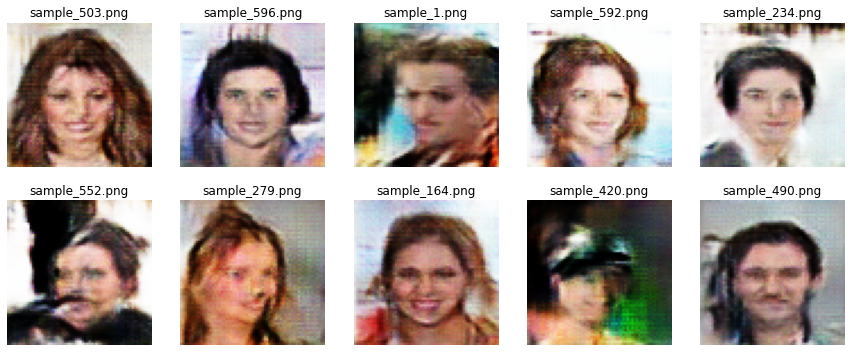

In [23]:
visualize(new_samples_dir, n_cols=5, n_rows=2)

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

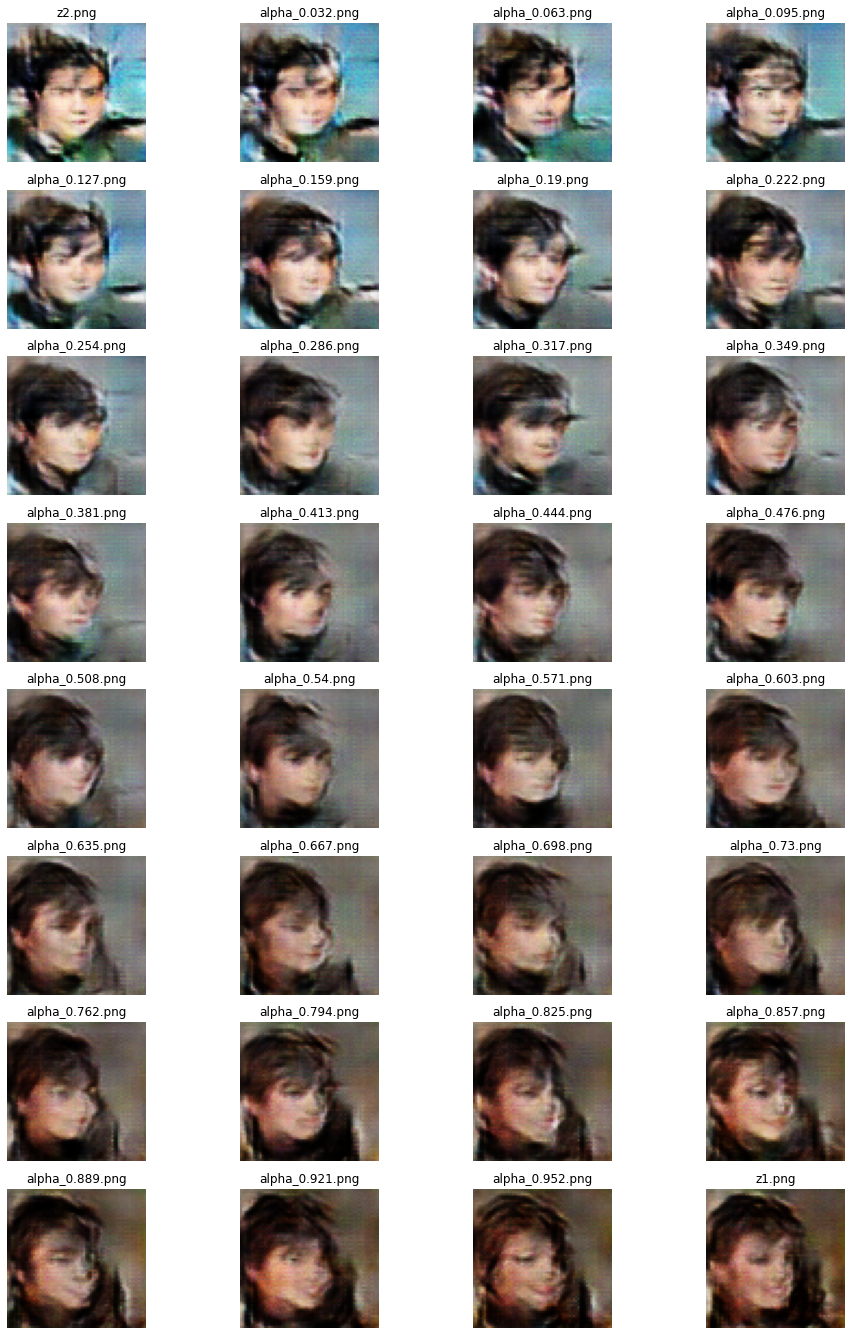

In [25]:
zs = np.random.uniform(-1, 1, [2, Z_DIM]).astype(np.float32)
alphas = np.linspace(0, 1, BATCH_SIZE)
batchz = np.zeros((BATCH_SIZE, Z_DIM))
for i, alpha in enumerate(alphas):
    batchz[i] = alpha*zs[0] + (1 - alpha)*zs[1]

samples = sess.run(G, feed_dict={z: batchz, is_training: False})
interpolation_dir = 'interpolation'
if not os.path.isdir(interpolation_dir):
    os.mkdir(interpolation_dir)
    
names = []
for i, sample in enumerate(samples):
    if i == 0:
        filename = 'z2.png'
        names.append(filename)
    elif i == len(samples) - 1:
        filename = 'z1.png'
        names.append(filename)
    else:
        filename = 'alpha_' + str(round(alphas[i], 3)) + '.png'
        if i&1 == 0 and i != len(samples) - 2:
            names.append(filename)
    plt.imsave(os.path.join(interpolation_dir, filename), (255*inverse_transform(sample)).astype(np.uint8))

plt.figure(figsize=(16, 24))
for i, name in enumerate(names):
    plt.subplot(8, 4, i+1)
    plt.axis('off')
    img = plt.imread(join(interpolation_dir, name))
    plt.imshow(img)
    plt.title(name)
plt.show()

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

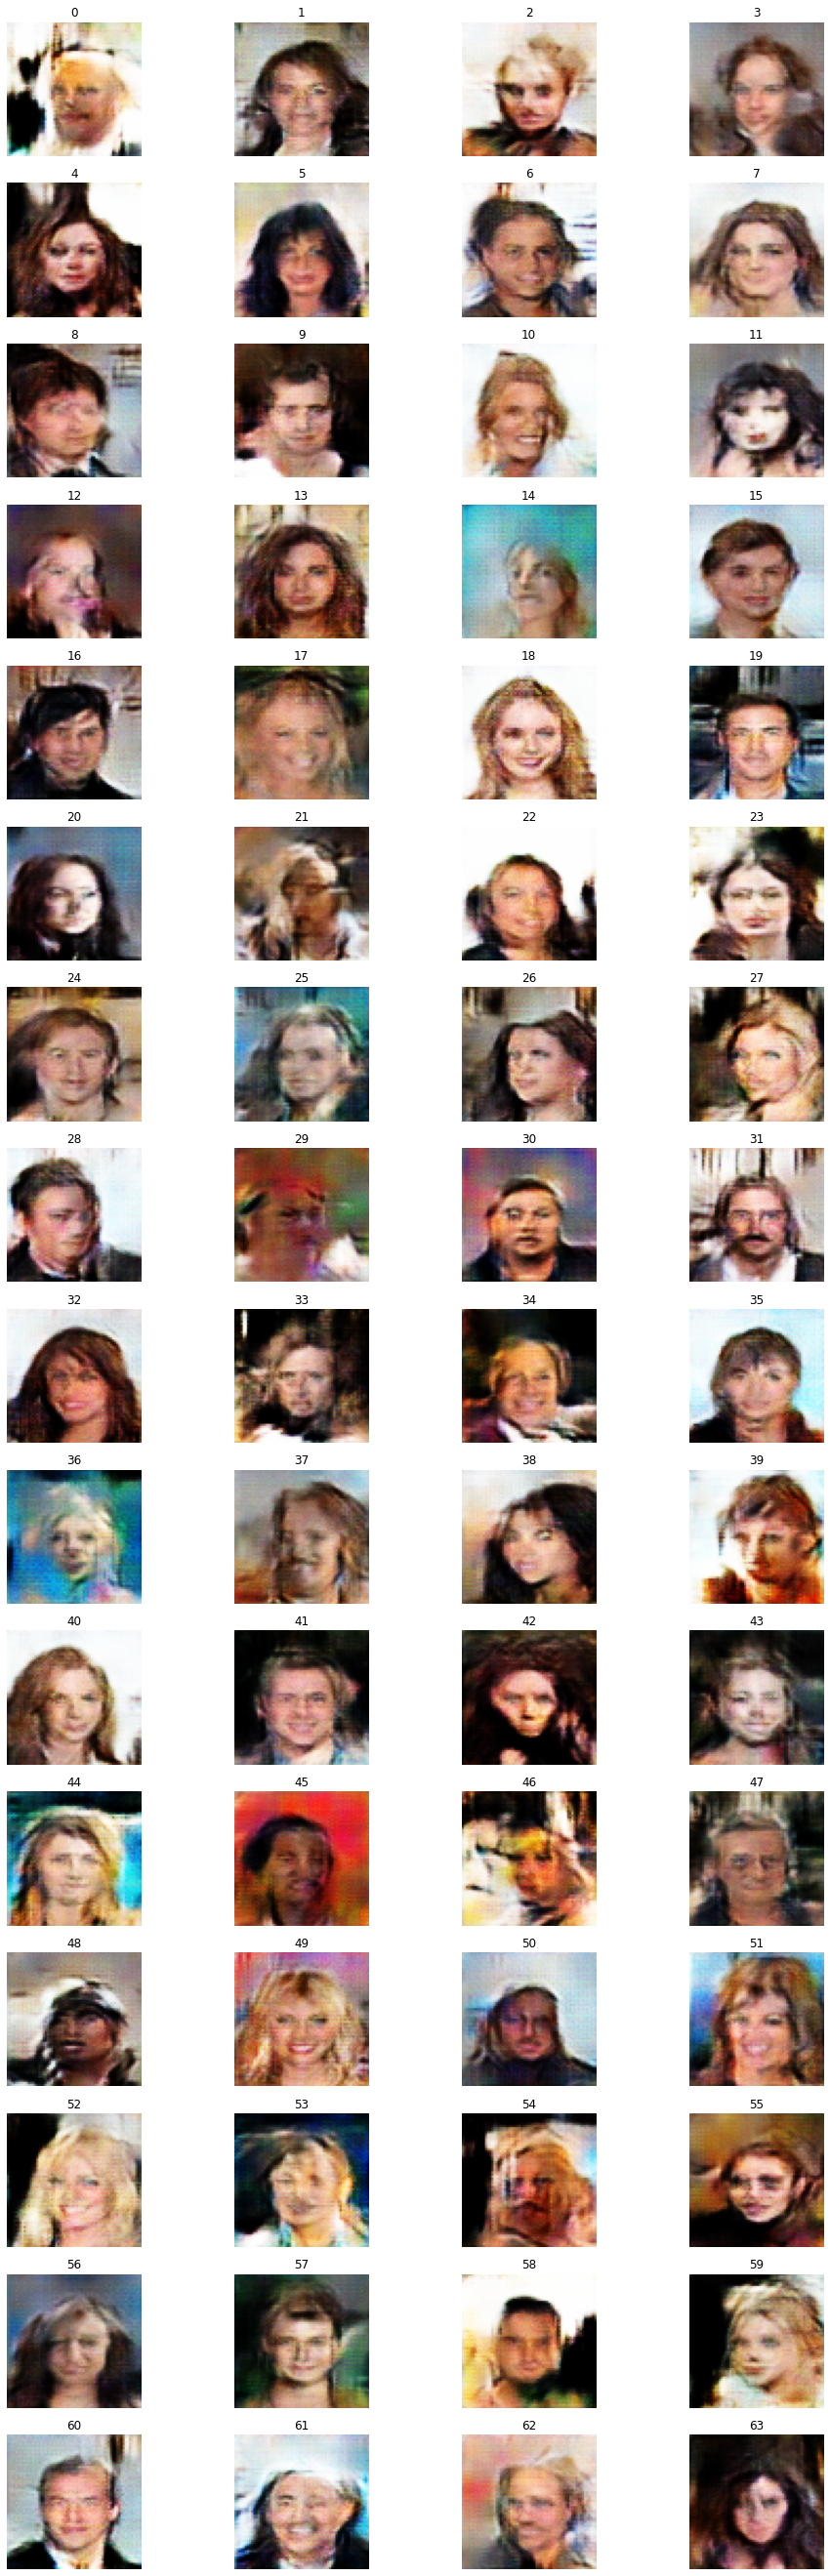

In [26]:
batchz = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
samples = sess.run(G, feed_dict={z: batchz, is_training: False})

plt.figure(figsize=(16, 48))
for i, sample in enumerate(samples):
    plt.subplot(16, 4, i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow((255*inverse_transform(sample)).astype(np.uint8))
plt.show()

If faces looks really cool, add bonus 1 point to your score.